# Semantic Segmentation Lab
In this lab, you will build a deep learning network that locates a particular human target within an image.  The premise is that a quadcopter (simulated) is searching for a target, and then will follow the target once found.  It's not enough to simply say the target is present in the image in this case, but rather to know *where* in the image the target is, so that the copter can adjust its direction in order to follow.

Consequently, an image classification network is not enough to solve the problem. Intead, a semantic segmentation network is needed so that the target can be specifically located within the image.

You can click on any of the following to quickly jump to that part of this notebook:
1. [Data Collection](#data)
2. [FCN Layers](#fcn)
3. [Build the Model](#build)
4. [Training](#training)
5. [Prediction](#prediction)
6. [Evaluation](#evaluation)

## Data Collection<a id='data'></a>
We have provided you with the dataset for this lab. If you haven't already downloaded the training and validation datasets, you can check out the README for this lab's repo for instructions as well.

In [16]:
import os
import glob
import sys
import tensorflow as tf

from scipy import misc
import numpy as np

from tensorflow.contrib.keras.python import keras
from tensorflow.contrib.keras.python.keras import layers, models

from tensorflow import image

from utils import scoring_utils
from utils.separable_conv2d import SeparableConv2DKeras, BilinearUpSampling2D
from utils import data_iterator
from utils import plotting_tools 
from utils import model_tools

## FCN Layers<a id='fcn'></a>
In the Classroom, we discussed the different layers that constitute a fully convolutional network. The following code will intoduce you to the functions that you will be using to build out your model.

### Separable Convolutions
The Encoder for your FCN will essentially require separable convolution layers. Below we have implemented two functions - one which you can call upon to build out separable convolutions or regular convolutions. Each with batch normalization and with the ReLU activation function applied to the layers. 

While we recommend the use of separable convolutions thanks to their advantages we covered in the Classroom, some of the helper code we will present for your model will require the use for regular convolutions. But we encourage you to try and experiment with each as well!

The following will help you create the encoder block and the final model for your architecture.

In [17]:
def separable_conv2d_batchnorm(input_layer, filters, strides=1):
    output_layer = SeparableConv2DKeras(filters=filters,kernel_size=3, strides=strides,
                             padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

#to use batchnorm after each seperable convolution layer to speed up training by reducing Internal covariate shift in each layer.
def conv2d_batchnorm(input_layer, filters, kernel_size=3, strides=1):
    output_layer = layers.Conv2D(filters=filters, kernel_size=kernel_size, strides=strides, 
                      padding='same', activation='relu')(input_layer)
    
    output_layer = layers.BatchNormalization()(output_layer) 
    return output_layer

### Bilinear Upsampling
The following helper function will help implement the bilinear upsampling layer. Currently, upsampling by a factor of 2 is recommended but you can try out different factors as well. You will use this to create the decoder block later!

In [18]:
def bilinear_upsample(input_layer):
    output_layer = BilinearUpSampling2D((2,2))(input_layer)
    return output_layer

## Build the Model<a id='build'></a>
In the following cells, we will cover how to build the model for the task at hand. 

- We will first create an Encoder Block, where you will create a separable convolution layer using an input layer and the size(depth) of the filters as your inputs.
- Next, you will create the Decoder Block, where you will create an upsampling layer using bilinear upsampling, followed by a layer concatentaion, and some separable convolution layers.
- Finally, you will combine the above two and create the model. In this step you will be able to experiment with different number of layers and filter sizes for each to build your model.

Let's cover them individually below.

### Encoder Block
Below you will create a separable convolution layer using the separable_conv2d_batchnorm() function. The `filters` parameter defines the size or depth of the output layer. For example, 32 or 64. 

In [19]:
def encoder_block(input_layer, filters, strides):
    
    # TODO Create a separable convolution layer using the separable_conv2d_batchnorm() function.
    output_layer = separable_conv2d_batchnorm(input_layer, filters, strides)
    
    return output_layer

### Decoder Block
The decoder block, as covered in the Classroom, comprises of three steps -

- A bilinear upsampling layer using the upsample_bilinear() function. The current recommended factor for upsampling is set to 2.
- A layer concatenation step. This step is similar to skip connections. You will concatenate the upsampled small_ip_layer and the large_ip_layer.
- Some (one or two) additional separable convolution layers to extract some more spatial information from prior layers.

In [20]:
def decoder_block(small_ip_layer, large_ip_layer, filters):
    
    # TODO Upsample the small input layer using the bilinear_upsample() function.
    upsampled = bilinear_upsample(small_ip_layer)
    
    # TODO Concatenate the upsampled and large input layers using layers.concatenate
    concat_layer = layers.concatenate([upsampled, large_ip_layer])
    
    # TODO Add some number of separable convolution layers
    output_layer = separable_conv2d_batchnorm(concat_layer, filters)
    
    return output_layer

### Model

Now that you have the encoder and decoder blocks ready, you can go ahead and build your model architecture! 

There are three steps to the following:
- Add encoder blocks to build out initial set of layers. This is similar to how you added regular convolutional layers in your CNN lab.
- Add 1x1 Convolution layer using conv2d_batchnorm() function. Remember that 1x1 Convolutions require a kernel and stride of 1.
- Add decoder blocks for upsampling and skip connections.

In [22]:
def fcn_model(inputs, num_classes):
    
    # TODO Add Encoder Blocks. 
    # Remember that with each encoder layer, the depth of your model (the number of filters) increases.
    l1 = encoder_block(inputs, 32, 2)
    l2 = encoder_block(l1, 64, 2)

    # TODO Add 1x1 Convolution layer using conv2d_batchnorm().
    l3 = conv2d_batchnorm(l2, 128, kernel_size=1, strides=1)
    
    # TODO: Add the same number of Decoder Blocks as the number of Encoder Blocks
    l4 = decoder_block(l3, l1, 64)
    l5 = decoder_block(l4, inputs, 32)
    
    
    # The function returns the output layer of your model. "x" is the final layer obtained from the last decoder_block()
    return layers.Conv2D(num_classes, 3, activation='softmax', padding='same')(l5)

## Training<a id='training'></a>
The following cells will utilize the model you created and define an ouput layer based on the input and the number of classes.Following that you will define the hyperparameters to compile and train your model!

In [21]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

image_hw = 128
image_shape = (image_hw, image_hw, 3)
inputs = layers.Input(image_shape)
num_classes = 3

# Call fcn_model()
output_layer = fcn_model(inputs, num_classes)

### Hyperparameters
Define and tune your hyperparameters.
- **batch_size**: number of training samples/images that get propagated through the network in a single pass.
- **num_epochs**: number of times the entire training dataset gets propagated through the network.
- **steps_per_epoch**: number of batches of training images that go through the network in 1 epoch. We have provided you with a default value. One recommended value to try would be based on the total number of images in training dataset divided by the batch_size.
- **validation_steps**: number of batches of validation images that go through the network in 1 epoch. This is similar to steps_per_epoch, except validation_steps is for the validation dataset. We have provided you with a default value for this as well.
- **workers**: maximum number of processes to spin up. This can affect your training speed and is dependent on your hardware. We have provided a recommended value to work with. 

In [28]:
learning_rate = 0.01
batch_size = 64
num_epochs = 200
steps_per_epoch = 300
validation_steps = 50
workers = 2

Epoch 1/200
299/300 [============================>.] - ETA: 0s - loss: 0.0422

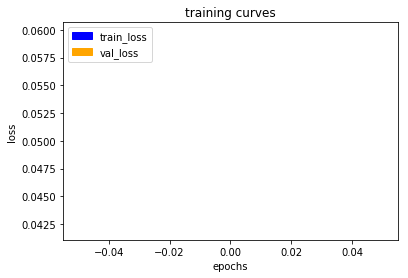

300/300 [==============================] - 152s - loss: 0.0422 - val_loss: 0.0598
Epoch 2/200
299/300 [============================>.] - ETA: 0s - loss: 0.0306

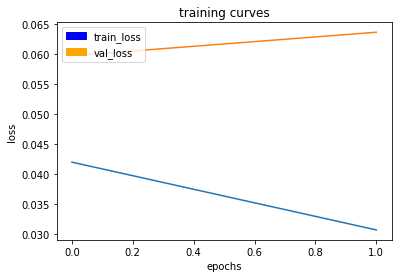

300/300 [==============================] - 152s - loss: 0.0306 - val_loss: 0.0637
Epoch 3/200
299/300 [============================>.] - ETA: 0s - loss: 0.0287

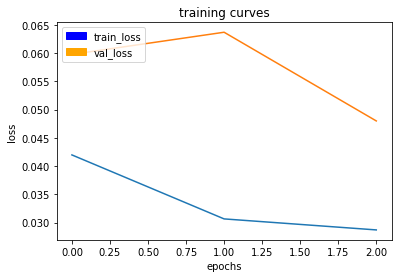

300/300 [==============================] - 151s - loss: 0.0287 - val_loss: 0.0480
Epoch 4/200
299/300 [============================>.] - ETA: 0s - loss: 0.0272

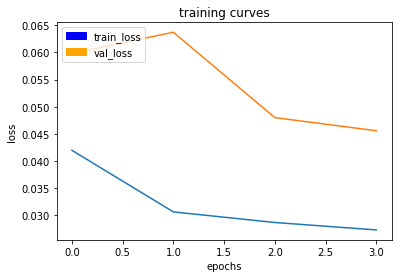

300/300 [==============================] - 150s - loss: 0.0272 - val_loss: 0.0456
Epoch 5/200
299/300 [============================>.] - ETA: 0s - loss: 0.0254

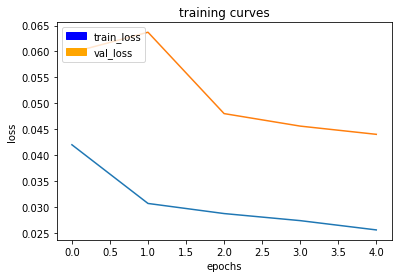

300/300 [==============================] - 148s - loss: 0.0254 - val_loss: 0.0440
Epoch 6/200
299/300 [============================>.] - ETA: 0s - loss: 0.0254

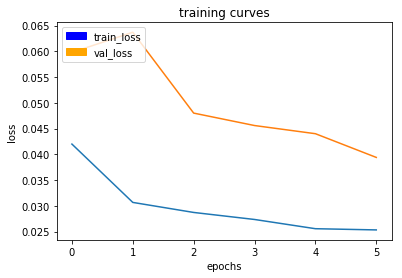

300/300 [==============================] - 148s - loss: 0.0254 - val_loss: 0.0394
Epoch 7/200
299/300 [============================>.] - ETA: 0s - loss: 0.0243

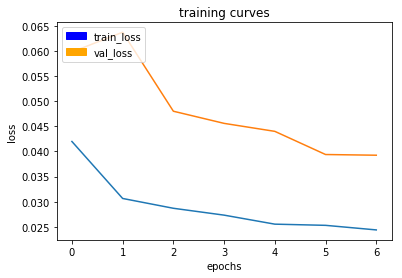

300/300 [==============================] - 148s - loss: 0.0244 - val_loss: 0.0393
Epoch 8/200
299/300 [============================>.] - ETA: 0s - loss: 0.0243

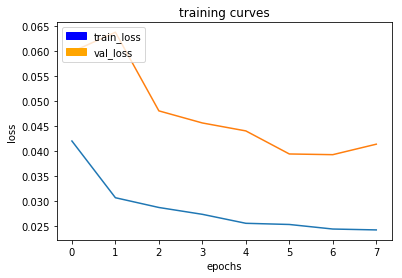

300/300 [==============================] - 148s - loss: 0.0243 - val_loss: 0.0413
Epoch 9/200
299/300 [============================>.] - ETA: 0s - loss: 0.0232

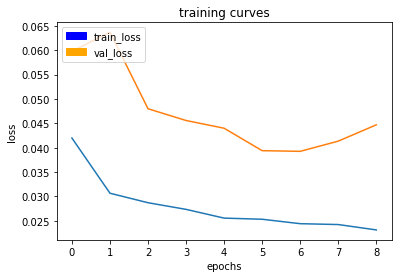

300/300 [==============================] - 148s - loss: 0.0232 - val_loss: 0.0447
Epoch 10/200
299/300 [============================>.] - ETA: 0s - loss: 0.0232

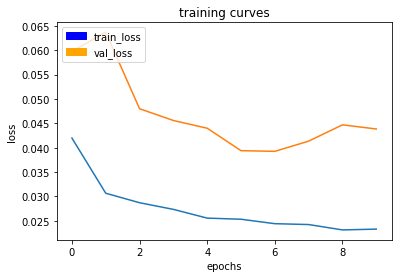

300/300 [==============================] - 148s - loss: 0.0232 - val_loss: 0.0438
Epoch 11/200
299/300 [============================>.] - ETA: 0s - loss: 0.0241

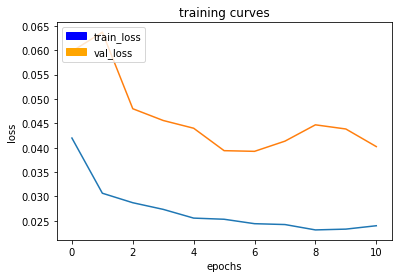

300/300 [==============================] - 148s - loss: 0.0241 - val_loss: 0.0402
Epoch 12/200
299/300 [============================>.] - ETA: 0s - loss: 0.0241

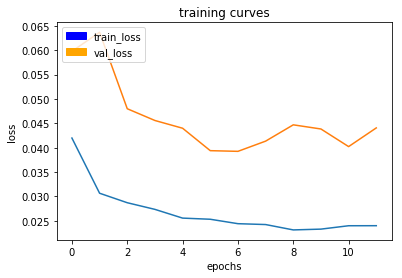

300/300 [==============================] - 148s - loss: 0.0241 - val_loss: 0.0441
Epoch 13/200
299/300 [============================>.] - ETA: 0s - loss: 0.0223

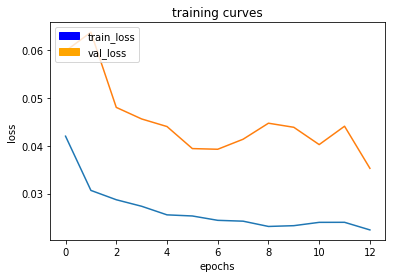

300/300 [==============================] - 148s - loss: 0.0223 - val_loss: 0.0353
Epoch 14/200
299/300 [============================>.] - ETA: 0s - loss: 0.0218

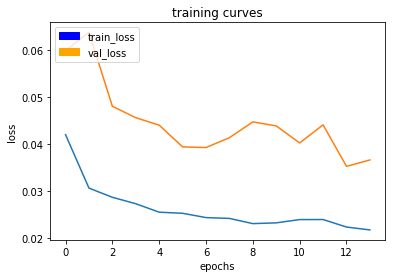

300/300 [==============================] - 148s - loss: 0.0217 - val_loss: 0.0366
Epoch 15/200
299/300 [============================>.] - ETA: 0s - loss: 0.0212

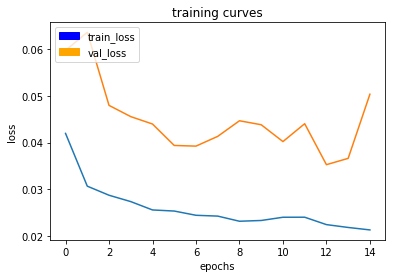

300/300 [==============================] - 149s - loss: 0.0212 - val_loss: 0.0504
Epoch 16/200
299/300 [============================>.] - ETA: 0s - loss: 0.0235

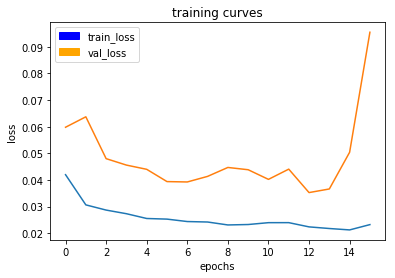

300/300 [==============================] - 148s - loss: 0.0235 - val_loss: 0.0954
Epoch 17/200
299/300 [============================>.] - ETA: 0s - loss: 0.0217

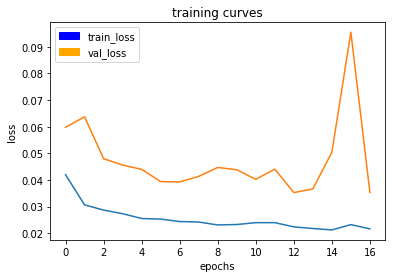

300/300 [==============================] - 148s - loss: 0.0217 - val_loss: 0.0353
Epoch 18/200
299/300 [============================>.] - ETA: 0s - loss: 0.0207

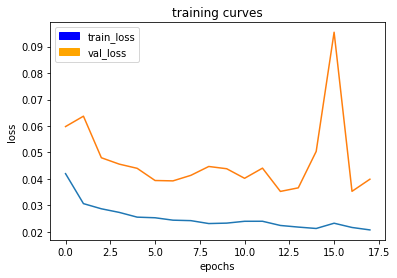

300/300 [==============================] - 149s - loss: 0.0207 - val_loss: 0.0399
Epoch 19/200
299/300 [============================>.] - ETA: 0s - loss: 0.0215

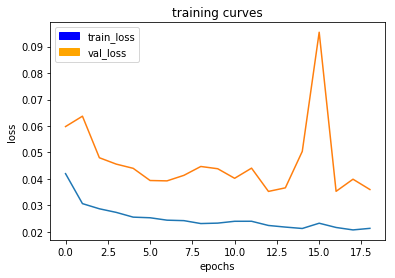

300/300 [==============================] - 149s - loss: 0.0214 - val_loss: 0.0360
Epoch 20/200
299/300 [============================>.] - ETA: 0s - loss: 0.0206

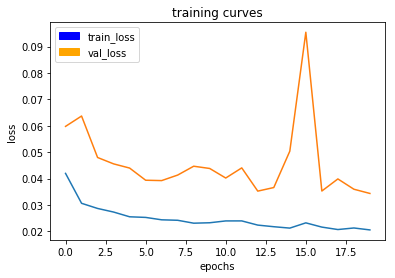

300/300 [==============================] - 148s - loss: 0.0206 - val_loss: 0.0344
Epoch 21/200
299/300 [============================>.] - ETA: 0s - loss: 0.0200

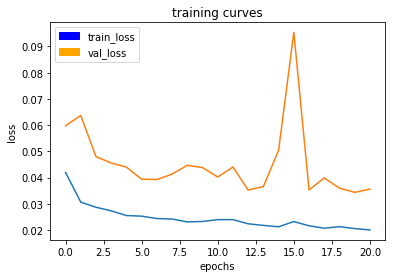

300/300 [==============================] - 149s - loss: 0.0200 - val_loss: 0.0356
Epoch 22/200
299/300 [============================>.] - ETA: 0s - loss: 0.0195

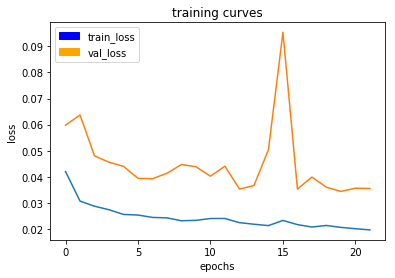

300/300 [==============================] - 148s - loss: 0.0195 - val_loss: 0.0355
Epoch 23/200
299/300 [============================>.] - ETA: 0s - loss: 0.0231

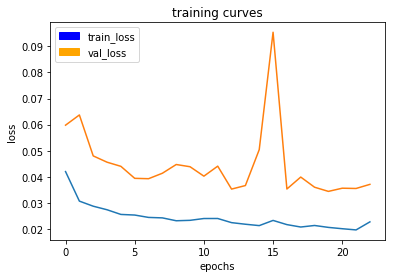

300/300 [==============================] - 148s - loss: 0.0231 - val_loss: 0.0371
Epoch 24/200
299/300 [============================>.] - ETA: 0s - loss: 0.0198

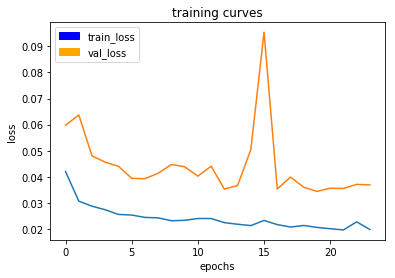

300/300 [==============================] - 149s - loss: 0.0198 - val_loss: 0.0369
Epoch 25/200
299/300 [============================>.] - ETA: 0s - loss: 0.0201

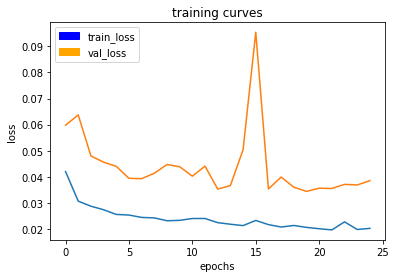

300/300 [==============================] - 148s - loss: 0.0202 - val_loss: 0.0385
Epoch 26/200
299/300 [============================>.] - ETA: 0s - loss: 0.0191

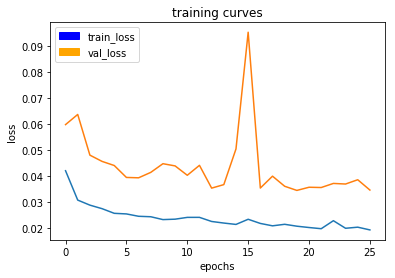

300/300 [==============================] - 148s - loss: 0.0191 - val_loss: 0.0345
Epoch 27/200
299/300 [============================>.] - ETA: 0s - loss: 0.0189

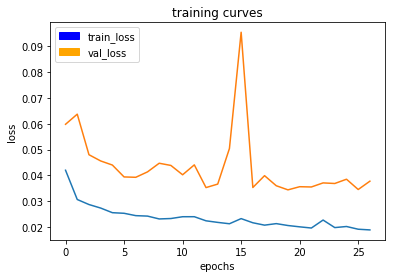

300/300 [==============================] - 148s - loss: 0.0189 - val_loss: 0.0377
Epoch 28/200
299/300 [============================>.] - ETA: 0s - loss: 0.0201

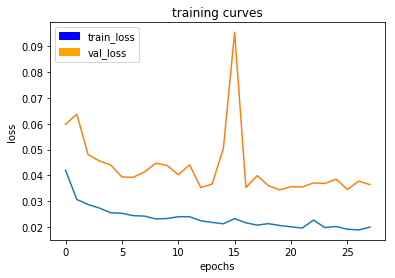

300/300 [==============================] - 149s - loss: 0.0201 - val_loss: 0.0364
Epoch 29/200
299/300 [============================>.] - ETA: 0s - loss: 0.0197

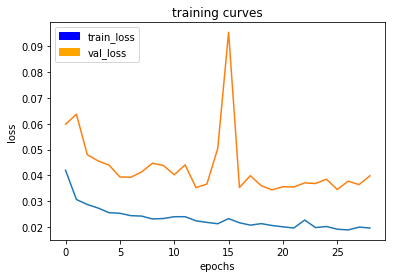

300/300 [==============================] - 148s - loss: 0.0197 - val_loss: 0.0398
Epoch 30/200
299/300 [============================>.] - ETA: 0s - loss: 0.0193

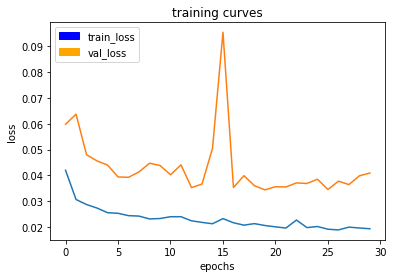

300/300 [==============================] - 148s - loss: 0.0193 - val_loss: 0.0409
Epoch 31/200
299/300 [============================>.] - ETA: 0s - loss: 0.0191

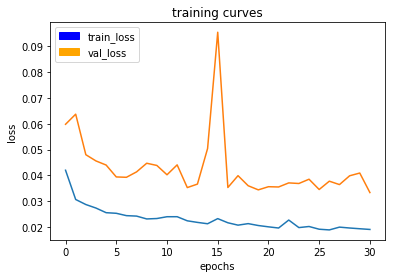

300/300 [==============================] - 148s - loss: 0.0191 - val_loss: 0.0333
Epoch 32/200
299/300 [============================>.] - ETA: 0s - loss: 0.0180

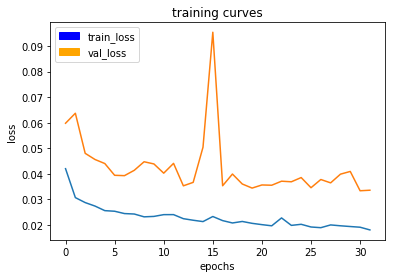

300/300 [==============================] - 149s - loss: 0.0180 - val_loss: 0.0335
Epoch 33/200
299/300 [============================>.] - ETA: 0s - loss: 0.0182

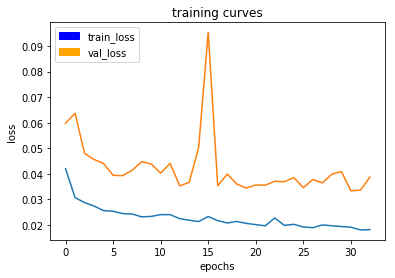

300/300 [==============================] - 149s - loss: 0.0182 - val_loss: 0.0387
Epoch 34/200
299/300 [============================>.] - ETA: 0s - loss: 0.0189

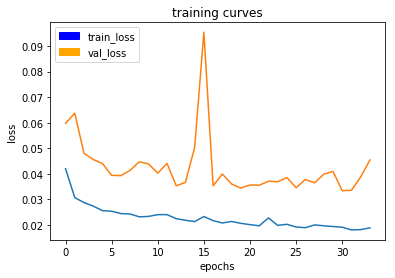

300/300 [==============================] - 148s - loss: 0.0189 - val_loss: 0.0454
Epoch 35/200
299/300 [============================>.] - ETA: 0s - loss: 0.0183

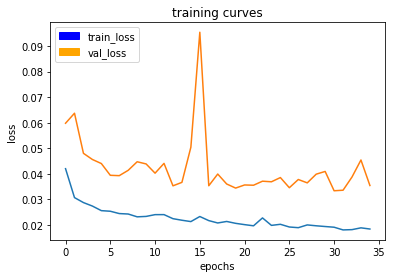

300/300 [==============================] - 148s - loss: 0.0183 - val_loss: 0.0354
Epoch 36/200
299/300 [============================>.] - ETA: 0s - loss: 0.0183

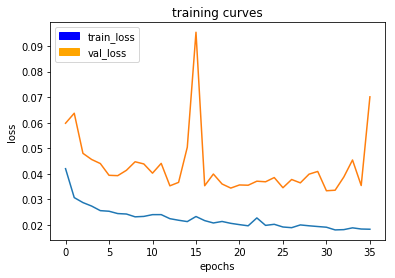

300/300 [==============================] - 148s - loss: 0.0183 - val_loss: 0.0701
Epoch 37/200
299/300 [============================>.] - ETA: 0s - loss: 0.0184

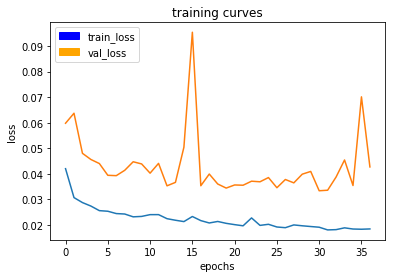

300/300 [==============================] - 148s - loss: 0.0184 - val_loss: 0.0427
Epoch 38/200
299/300 [============================>.] - ETA: 0s - loss: 0.0205

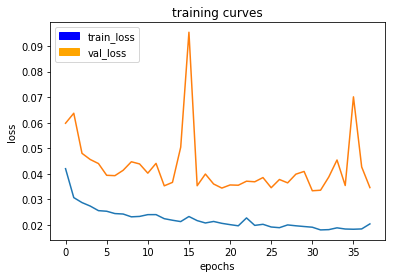

300/300 [==============================] - 148s - loss: 0.0205 - val_loss: 0.0346
Epoch 39/200
299/300 [============================>.] - ETA: 0s - loss: 0.0212

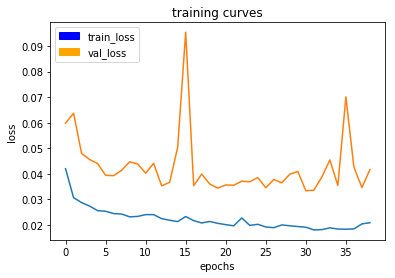

300/300 [==============================] - 149s - loss: 0.0212 - val_loss: 0.0416
Epoch 40/200
299/300 [============================>.] - ETA: 0s - loss: 0.0190

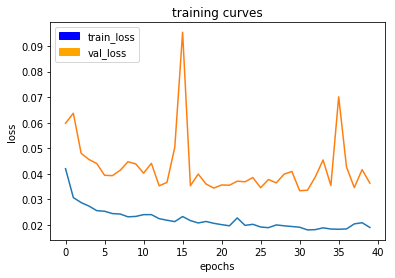

300/300 [==============================] - 149s - loss: 0.0189 - val_loss: 0.0363
Epoch 41/200
299/300 [============================>.] - ETA: 0s - loss: 0.0180

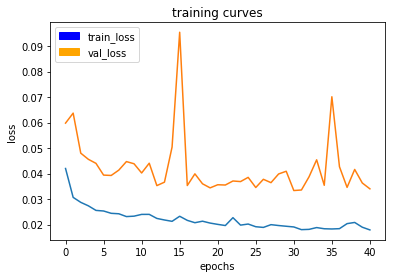

300/300 [==============================] - 148s - loss: 0.0180 - val_loss: 0.0340
Epoch 42/200
299/300 [============================>.] - ETA: 0s - loss: 0.0183

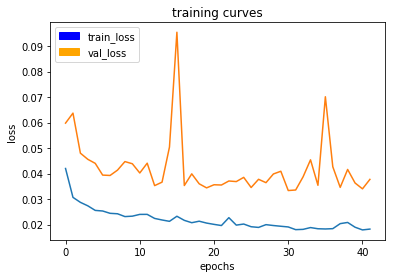

300/300 [==============================] - 149s - loss: 0.0183 - val_loss: 0.0377
Epoch 43/200
299/300 [============================>.] - ETA: 0s - loss: 0.0169

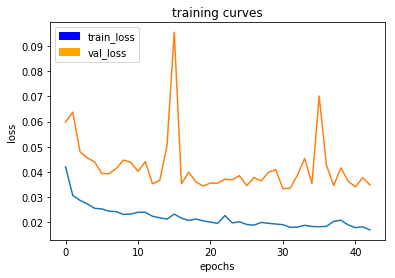

300/300 [==============================] - 148s - loss: 0.0169 - val_loss: 0.0348
Epoch 44/200
299/300 [============================>.] - ETA: 0s - loss: 0.0176

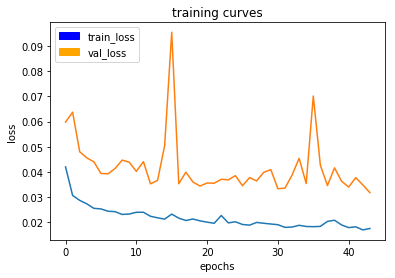

300/300 [==============================] - 149s - loss: 0.0176 - val_loss: 0.0318
Epoch 45/200
299/300 [============================>.] - ETA: 0s - loss: 0.0172

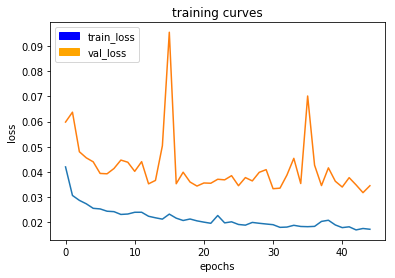

300/300 [==============================] - 149s - loss: 0.0172 - val_loss: 0.0345
Epoch 46/200
299/300 [============================>.] - ETA: 0s - loss: 0.0172

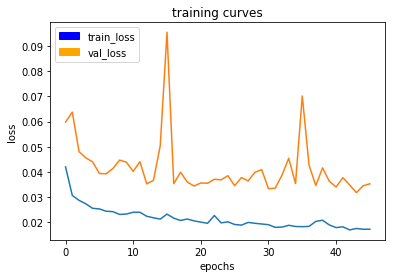

300/300 [==============================] - 149s - loss: 0.0172 - val_loss: 0.0353
Epoch 47/200
299/300 [============================>.] - ETA: 0s - loss: 0.0178

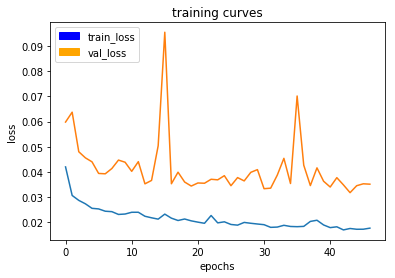

300/300 [==============================] - 149s - loss: 0.0177 - val_loss: 0.0351
Epoch 48/200
299/300 [============================>.] - ETA: 0s - loss: 0.0180

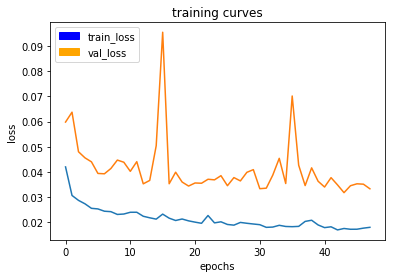

300/300 [==============================] - 149s - loss: 0.0181 - val_loss: 0.0333
Epoch 49/200
299/300 [============================>.] - ETA: 0s - loss: 0.0166

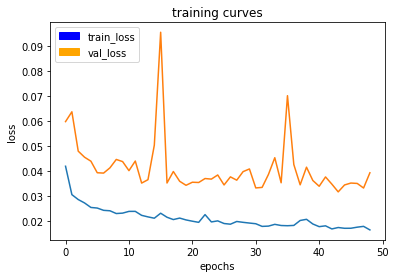

300/300 [==============================] - 149s - loss: 0.0166 - val_loss: 0.0394
Epoch 50/200
299/300 [============================>.] - ETA: 0s - loss: 0.0179

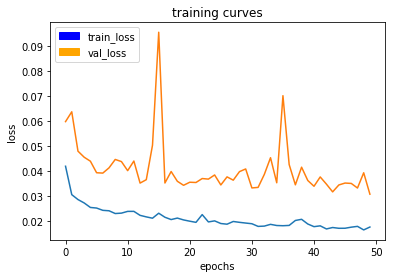

300/300 [==============================] - 149s - loss: 0.0179 - val_loss: 0.0308
Epoch 51/200
299/300 [============================>.] - ETA: 0s - loss: 0.0167

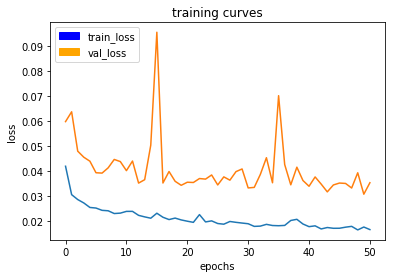

300/300 [==============================] - 149s - loss: 0.0167 - val_loss: 0.0354
Epoch 52/200
299/300 [============================>.] - ETA: 0s - loss: 0.0165

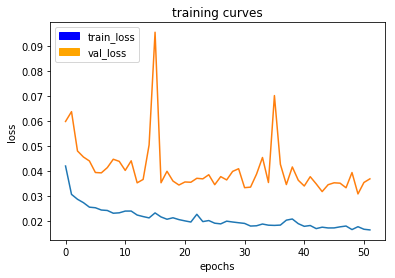

300/300 [==============================] - 149s - loss: 0.0165 - val_loss: 0.0369
Epoch 53/200
299/300 [============================>.] - ETA: 0s - loss: 0.0169

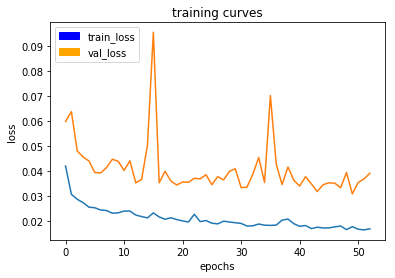

300/300 [==============================] - 149s - loss: 0.0169 - val_loss: 0.0391
Epoch 54/200
299/300 [============================>.] - ETA: 0s - loss: 0.0166

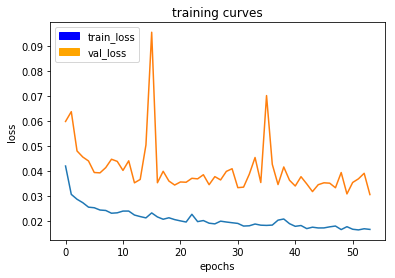

300/300 [==============================] - 148s - loss: 0.0166 - val_loss: 0.0306
Epoch 55/200
299/300 [============================>.] - ETA: 0s - loss: 0.0170

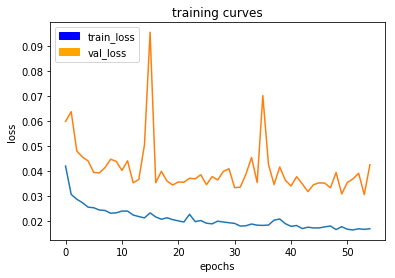

300/300 [==============================] - 148s - loss: 0.0170 - val_loss: 0.0425
Epoch 56/200
299/300 [============================>.] - ETA: 0s - loss: 0.0165

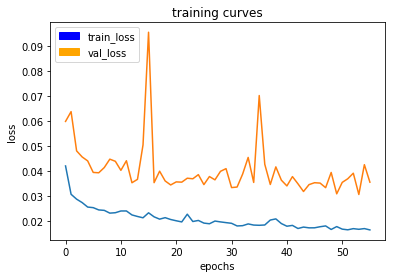

300/300 [==============================] - 149s - loss: 0.0165 - val_loss: 0.0355
Epoch 57/200
299/300 [============================>.] - ETA: 0s - loss: 0.0176

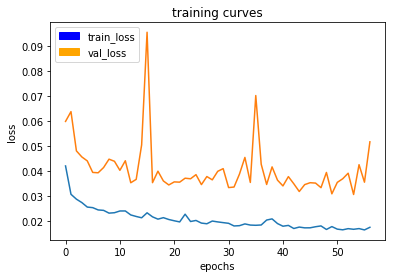

300/300 [==============================] - 149s - loss: 0.0176 - val_loss: 0.0516
Epoch 58/200
299/300 [============================>.] - ETA: 0s - loss: 0.0162

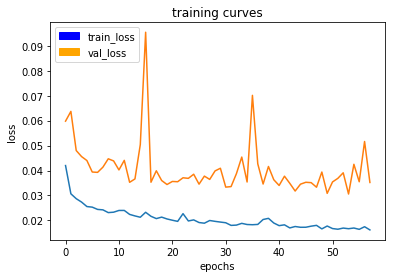

300/300 [==============================] - 149s - loss: 0.0162 - val_loss: 0.0352
Epoch 59/200
299/300 [============================>.] - ETA: 0s - loss: 0.0162

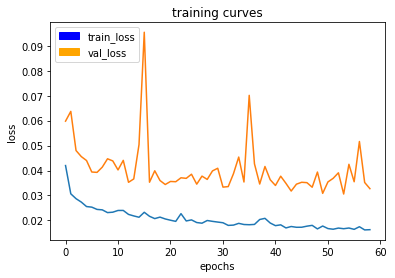

300/300 [==============================] - 149s - loss: 0.0162 - val_loss: 0.0327
Epoch 60/200
299/300 [============================>.] - ETA: 0s - loss: 0.0176

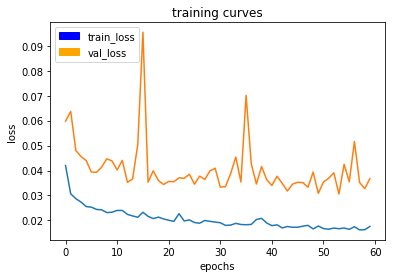

300/300 [==============================] - 149s - loss: 0.0175 - val_loss: 0.0367
Epoch 61/200
299/300 [============================>.] - ETA: 0s - loss: 0.0168

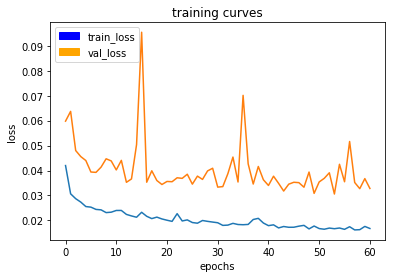

300/300 [==============================] - 149s - loss: 0.0168 - val_loss: 0.0328
Epoch 62/200
299/300 [============================>.] - ETA: 0s - loss: 0.0160

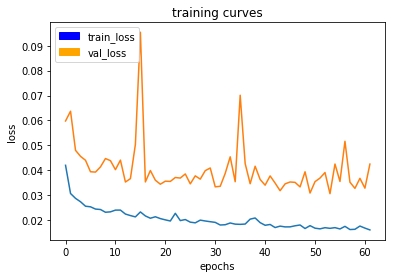

300/300 [==============================] - 149s - loss: 0.0160 - val_loss: 0.0425
Epoch 63/200
299/300 [============================>.] - ETA: 0s - loss: 0.0162

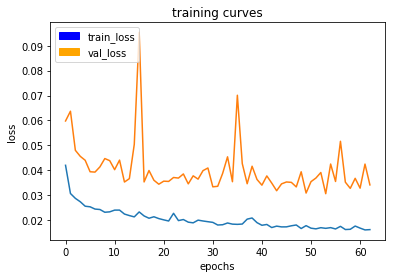

300/300 [==============================] - 149s - loss: 0.0162 - val_loss: 0.0341
Epoch 64/200
299/300 [============================>.] - ETA: 0s - loss: 0.0162

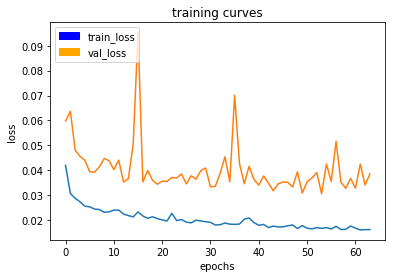

300/300 [==============================] - 149s - loss: 0.0162 - val_loss: 0.0385
Epoch 65/200
299/300 [============================>.] - ETA: 0s - loss: 0.0167

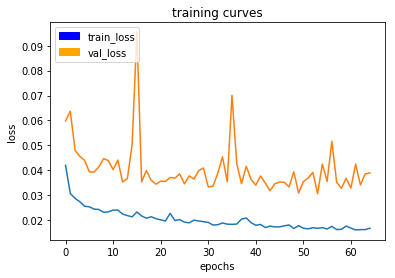

300/300 [==============================] - 150s - loss: 0.0167 - val_loss: 0.0389
Epoch 66/200
299/300 [============================>.] - ETA: 0s - loss: 0.0157

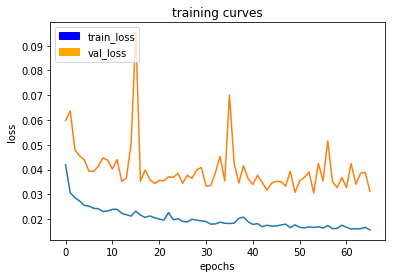

300/300 [==============================] - 149s - loss: 0.0157 - val_loss: 0.0313
Epoch 67/200
299/300 [============================>.] - ETA: 0s - loss: 0.0161

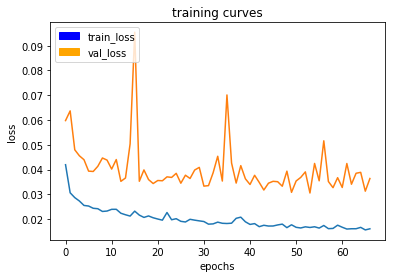

300/300 [==============================] - 149s - loss: 0.0161 - val_loss: 0.0364
Epoch 68/200
299/300 [============================>.] - ETA: 0s - loss: 0.0160

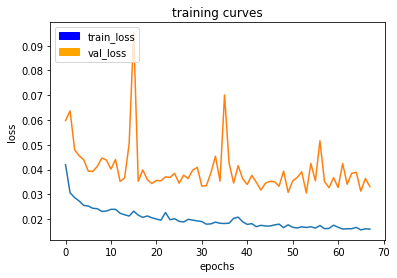

300/300 [==============================] - 149s - loss: 0.0160 - val_loss: 0.0331
Epoch 69/200
299/300 [============================>.] - ETA: 0s - loss: 0.0155

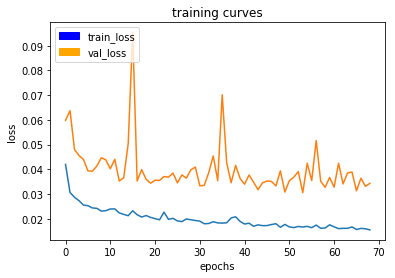

300/300 [==============================] - 150s - loss: 0.0155 - val_loss: 0.0344
Epoch 70/200
299/300 [============================>.] - ETA: 0s - loss: 0.0161

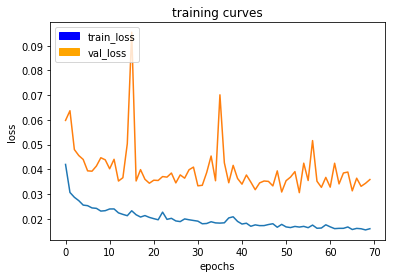

300/300 [==============================] - 150s - loss: 0.0161 - val_loss: 0.0359
Epoch 71/200
299/300 [============================>.] - ETA: 0s - loss: 0.0161

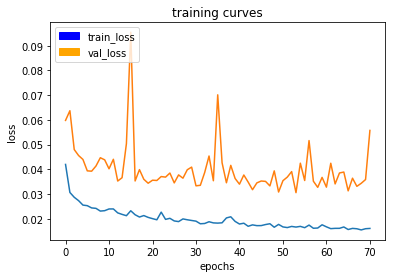

300/300 [==============================] - 149s - loss: 0.0161 - val_loss: 0.0557
Epoch 72/200
299/300 [============================>.] - ETA: 0s - loss: 0.0159

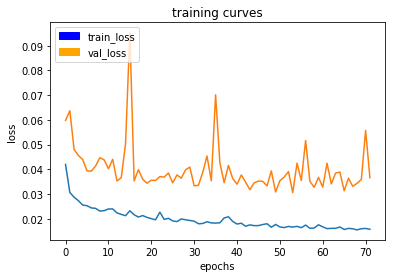

300/300 [==============================] - 150s - loss: 0.0158 - val_loss: 0.0366
Epoch 73/200
299/300 [============================>.] - ETA: 0s - loss: 0.0156

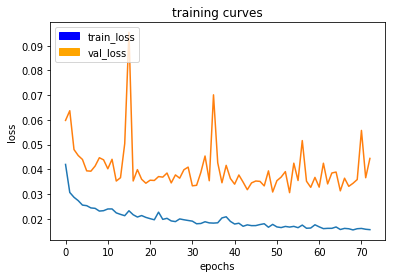

300/300 [==============================] - 150s - loss: 0.0156 - val_loss: 0.0444
Epoch 74/200
299/300 [============================>.] - ETA: 0s - loss: 0.0161

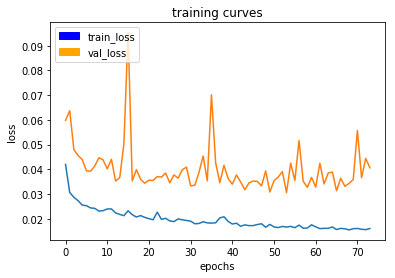

300/300 [==============================] - 149s - loss: 0.0161 - val_loss: 0.0406
Epoch 75/200
299/300 [============================>.] - ETA: 0s - loss: 0.0157

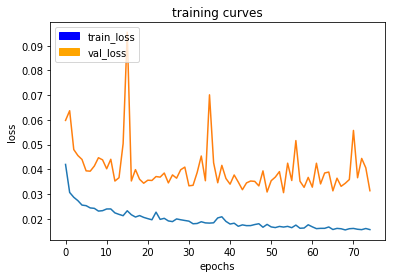

300/300 [==============================] - 149s - loss: 0.0157 - val_loss: 0.0314
Epoch 76/200
299/300 [============================>.] - ETA: 0s - loss: 0.0158

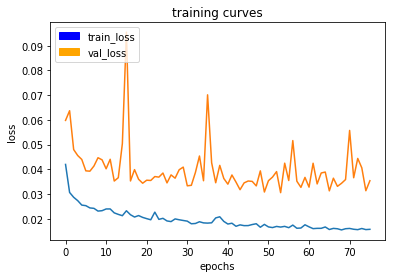

300/300 [==============================] - 149s - loss: 0.0157 - val_loss: 0.0354
Epoch 77/200
299/300 [============================>.] - ETA: 0s - loss: 0.0152

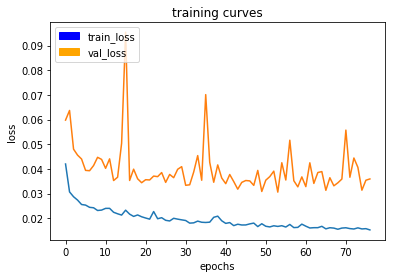

300/300 [==============================] - 149s - loss: 0.0152 - val_loss: 0.0359
Epoch 78/200
299/300 [============================>.] - ETA: 0s - loss: 0.0170

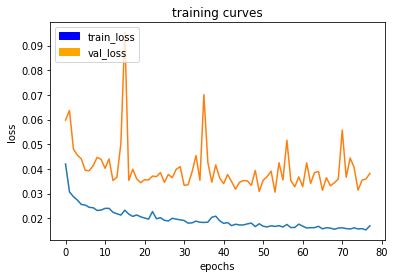

300/300 [==============================] - 149s - loss: 0.0170 - val_loss: 0.0382
Epoch 79/200
299/300 [============================>.] - ETA: 0s - loss: 0.0156

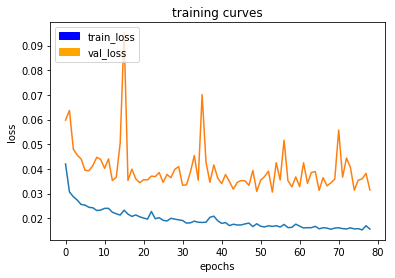

300/300 [==============================] - 149s - loss: 0.0156 - val_loss: 0.0314
Epoch 80/200
299/300 [============================>.] - ETA: 0s - loss: 0.0152

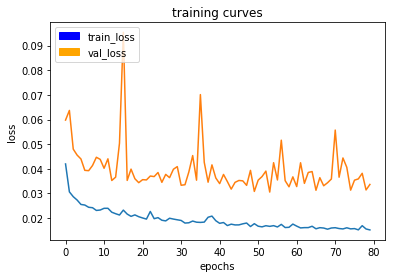

300/300 [==============================] - 149s - loss: 0.0152 - val_loss: 0.0337
Epoch 81/200
299/300 [============================>.] - ETA: 0s - loss: 0.0152

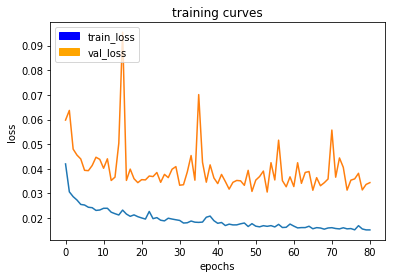

300/300 [==============================] - 149s - loss: 0.0152 - val_loss: 0.0344
Epoch 82/200
299/300 [============================>.] - ETA: 0s - loss: 0.0156

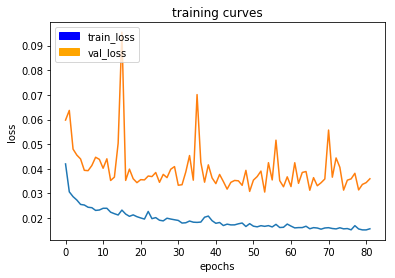

300/300 [==============================] - 149s - loss: 0.0156 - val_loss: 0.0360
Epoch 83/200
299/300 [============================>.] - ETA: 0s - loss: 0.0184

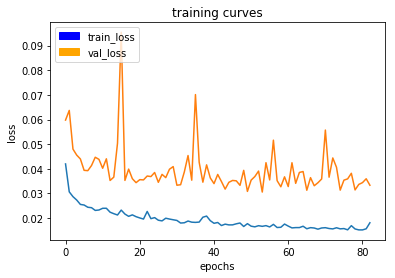

300/300 [==============================] - 149s - loss: 0.0184 - val_loss: 0.0333
Epoch 84/200
299/300 [============================>.] - ETA: 0s - loss: 0.0157

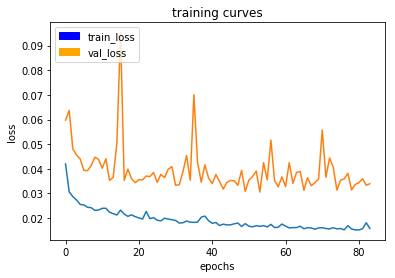

300/300 [==============================] - 149s - loss: 0.0157 - val_loss: 0.0339
Epoch 85/200
299/300 [============================>.] - ETA: 0s - loss: 0.0156

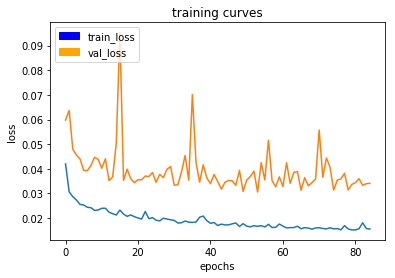

300/300 [==============================] - 149s - loss: 0.0156 - val_loss: 0.0341
Epoch 86/200
299/300 [============================>.] - ETA: 0s - loss: 0.0150

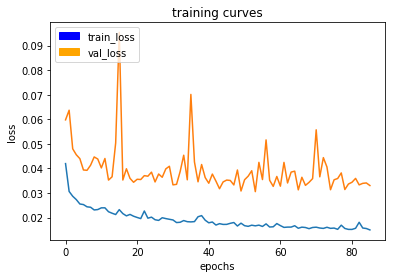

300/300 [==============================] - 150s - loss: 0.0150 - val_loss: 0.0331
Epoch 87/200
299/300 [============================>.] - ETA: 0s - loss: 0.0151

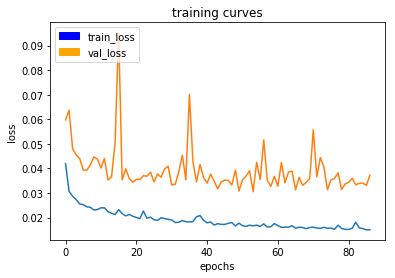

300/300 [==============================] - 149s - loss: 0.0151 - val_loss: 0.0373
Epoch 88/200
299/300 [============================>.] - ETA: 0s - loss: 0.0149

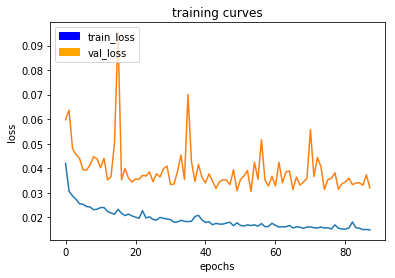

300/300 [==============================] - 149s - loss: 0.0149 - val_loss: 0.0320
Epoch 89/200
299/300 [============================>.] - ETA: 0s - loss: 0.0150

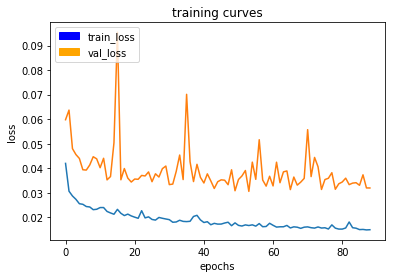

300/300 [==============================] - 149s - loss: 0.0150 - val_loss: 0.0320
Epoch 90/200
299/300 [============================>.] - ETA: 0s - loss: 0.0182

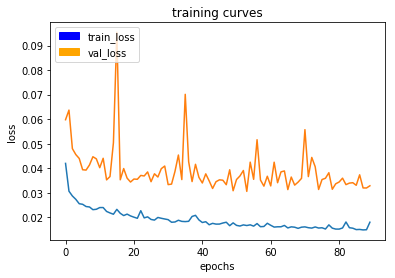

300/300 [==============================] - 149s - loss: 0.0182 - val_loss: 0.0329
Epoch 91/200
299/300 [============================>.] - ETA: 0s - loss: 0.0148

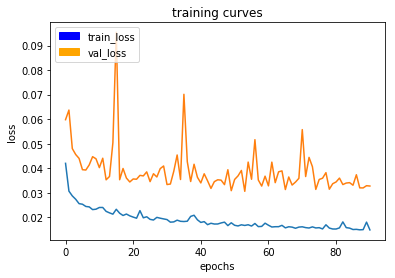

300/300 [==============================] - 149s - loss: 0.0148 - val_loss: 0.0327
Epoch 92/200
299/300 [============================>.] - ETA: 0s - loss: 0.0151

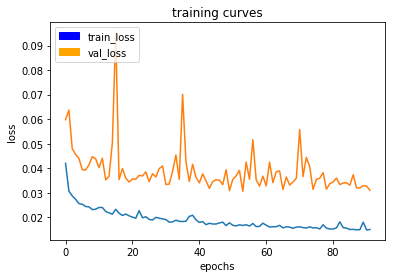

300/300 [==============================] - 150s - loss: 0.0151 - val_loss: 0.0310
Epoch 93/200
299/300 [============================>.] - ETA: 0s - loss: 0.0158

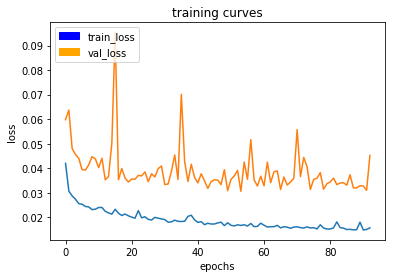

300/300 [==============================] - 149s - loss: 0.0157 - val_loss: 0.0452
Epoch 94/200
299/300 [============================>.] - ETA: 0s - loss: 0.0153

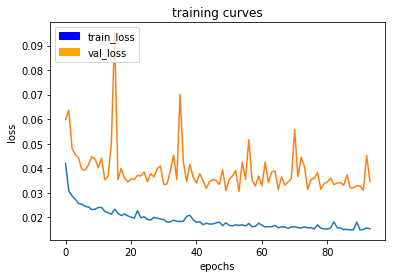

300/300 [==============================] - 149s - loss: 0.0153 - val_loss: 0.0346
Epoch 95/200
299/300 [============================>.] - ETA: 0s - loss: 0.0148

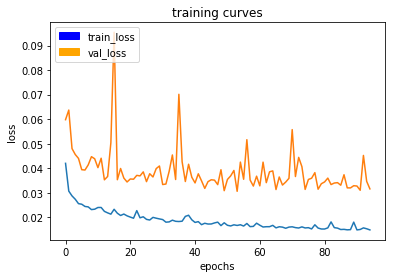

300/300 [==============================] - 150s - loss: 0.0148 - val_loss: 0.0316
Epoch 96/200
299/300 [============================>.] - ETA: 0s - loss: 0.0156

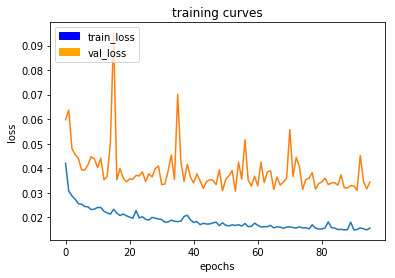

300/300 [==============================] - 149s - loss: 0.0156 - val_loss: 0.0343
Epoch 97/200
299/300 [============================>.] - ETA: 0s - loss: 0.0149

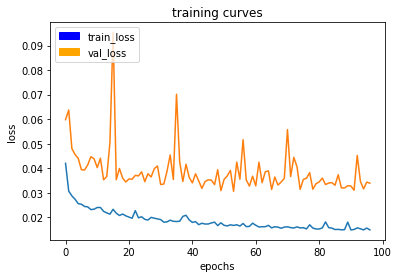

300/300 [==============================] - 149s - loss: 0.0149 - val_loss: 0.0339
Epoch 98/200
299/300 [============================>.] - ETA: 0s - loss: 0.0150

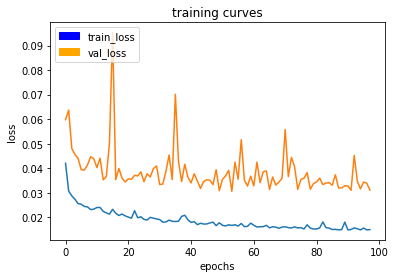

300/300 [==============================] - 150s - loss: 0.0150 - val_loss: 0.0311
Epoch 99/200
299/300 [============================>.] - ETA: 0s - loss: 0.0150

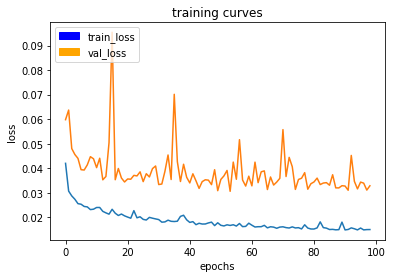

300/300 [==============================] - 149s - loss: 0.0150 - val_loss: 0.0328
Epoch 100/200
299/300 [============================>.] - ETA: 0s - loss: 0.0153

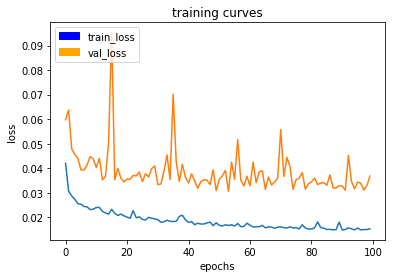

300/300 [==============================] - 150s - loss: 0.0153 - val_loss: 0.0368
Epoch 101/200
299/300 [============================>.] - ETA: 0s - loss: 0.0156

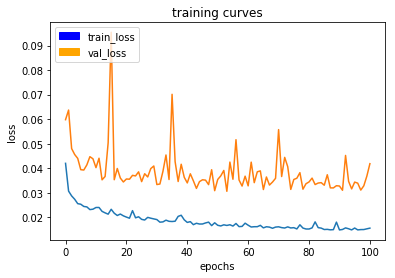

300/300 [==============================] - 149s - loss: 0.0156 - val_loss: 0.0418
Epoch 102/200
299/300 [============================>.] - ETA: 0s - loss: 0.0158

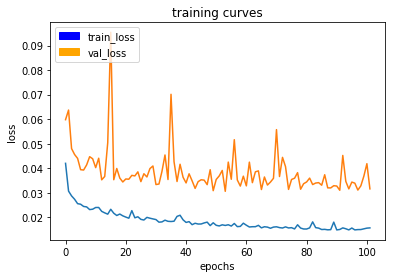

300/300 [==============================] - 150s - loss: 0.0158 - val_loss: 0.0316
Epoch 103/200
299/300 [============================>.] - ETA: 0s - loss: 0.0147

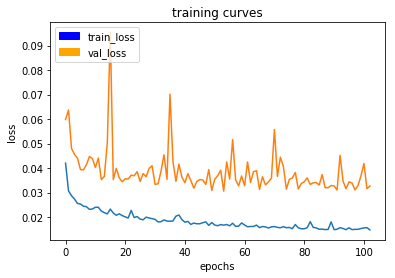

300/300 [==============================] - 150s - loss: 0.0147 - val_loss: 0.0326
Epoch 104/200
299/300 [============================>.] - ETA: 0s - loss: 0.0148

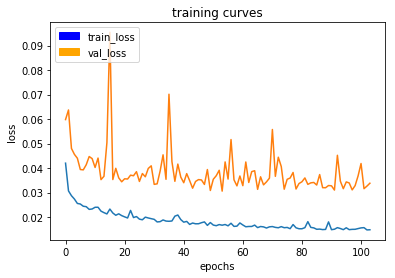

300/300 [==============================] - 150s - loss: 0.0148 - val_loss: 0.0338
Epoch 105/200
299/300 [============================>.] - ETA: 0s - loss: 0.0151

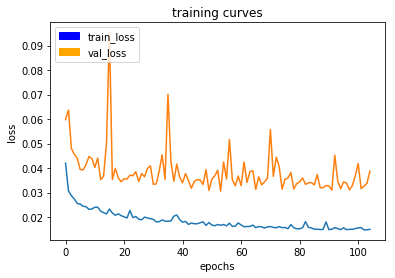

300/300 [==============================] - 150s - loss: 0.0151 - val_loss: 0.0388
Epoch 106/200
299/300 [============================>.] - ETA: 0s - loss: 0.0151

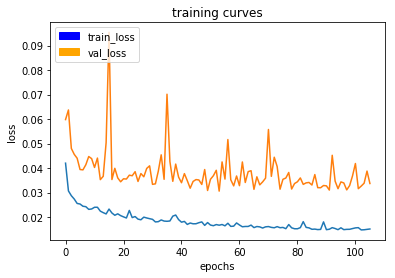

300/300 [==============================] - 150s - loss: 0.0151 - val_loss: 0.0337
Epoch 107/200
299/300 [============================>.] - ETA: 0s - loss: 0.0152

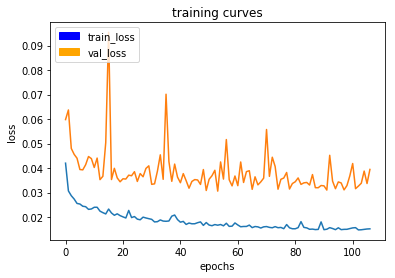

300/300 [==============================] - 150s - loss: 0.0152 - val_loss: 0.0394
Epoch 108/200
299/300 [============================>.] - ETA: 0s - loss: 0.0160

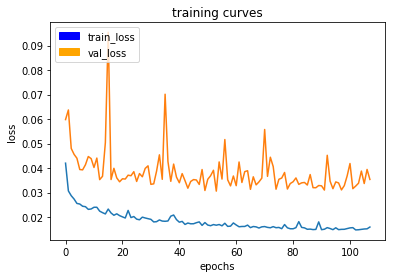

300/300 [==============================] - 150s - loss: 0.0160 - val_loss: 0.0353
Epoch 109/200
299/300 [============================>.] - ETA: 0s - loss: 0.0144

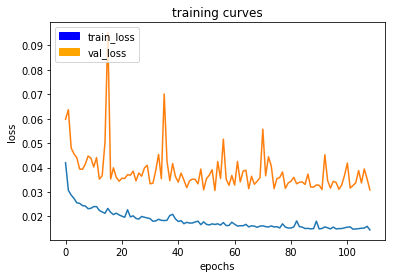

300/300 [==============================] - 150s - loss: 0.0144 - val_loss: 0.0308
Epoch 110/200
299/300 [============================>.] - ETA: 0s - loss: 0.0144

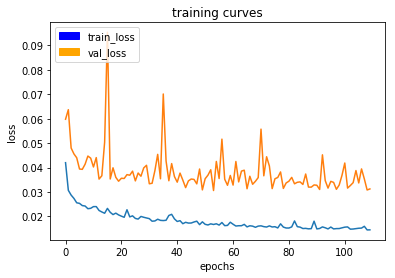

300/300 [==============================] - 150s - loss: 0.0144 - val_loss: 0.0312
Epoch 111/200
299/300 [============================>.] - ETA: 0s - loss: 0.0145

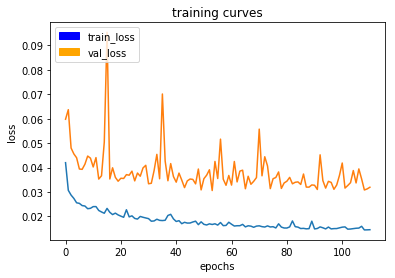

300/300 [==============================] - 150s - loss: 0.0145 - val_loss: 0.0319
Epoch 112/200
299/300 [============================>.] - ETA: 0s - loss: 0.0156

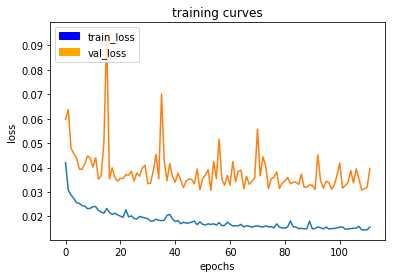

300/300 [==============================] - 150s - loss: 0.0156 - val_loss: 0.0396
Epoch 113/200
299/300 [============================>.] - ETA: 0s - loss: 0.0170

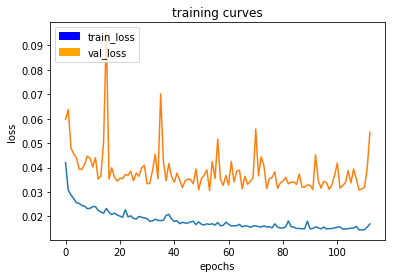

300/300 [==============================] - 150s - loss: 0.0170 - val_loss: 0.0544
Epoch 114/200
299/300 [============================>.] - ETA: 0s - loss: 0.0165

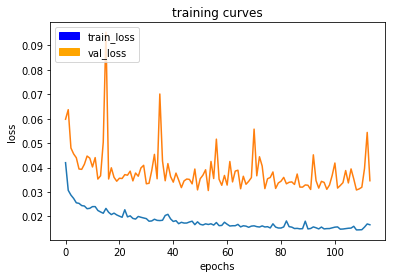

300/300 [==============================] - 150s - loss: 0.0165 - val_loss: 0.0346
Epoch 115/200
299/300 [============================>.] - ETA: 0s - loss: 0.0149

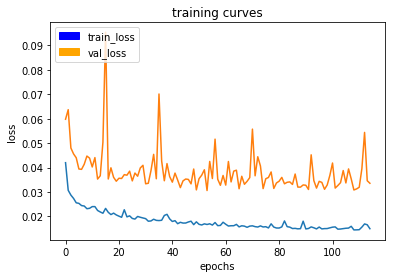

300/300 [==============================] - 150s - loss: 0.0149 - val_loss: 0.0335
Epoch 116/200
299/300 [============================>.] - ETA: 0s - loss: 0.0146

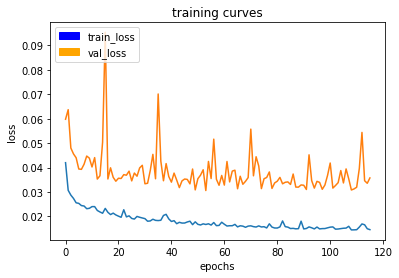

300/300 [==============================] - 150s - loss: 0.0146 - val_loss: 0.0357
Epoch 117/200
299/300 [============================>.] - ETA: 0s - loss: 0.0145

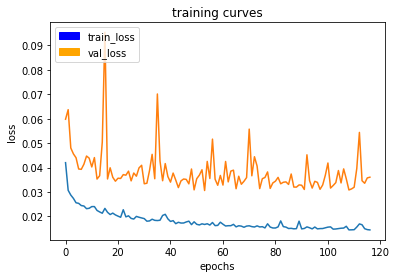

300/300 [==============================] - 149s - loss: 0.0145 - val_loss: 0.0360
Epoch 118/200
299/300 [============================>.] - ETA: 0s - loss: 0.0142

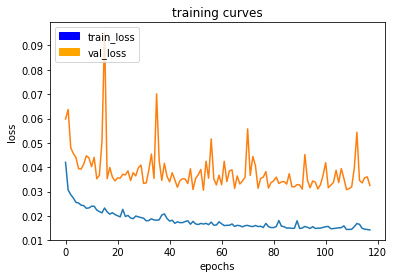

300/300 [==============================] - 149s - loss: 0.0142 - val_loss: 0.0325
Epoch 119/200
299/300 [============================>.] - ETA: 0s - loss: 0.0153

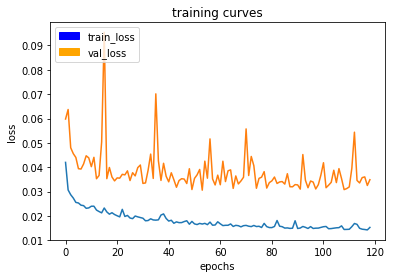

300/300 [==============================] - 150s - loss: 0.0153 - val_loss: 0.0349
Epoch 120/200
299/300 [============================>.] - ETA: 0s - loss: 0.0152

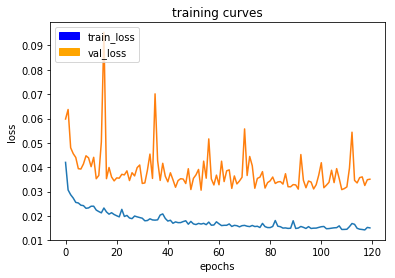

300/300 [==============================] - 150s - loss: 0.0152 - val_loss: 0.0351
Epoch 121/200
299/300 [============================>.] - ETA: 0s - loss: 0.0144

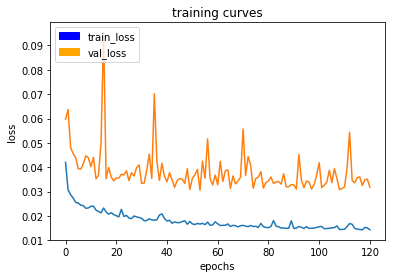

300/300 [==============================] - 150s - loss: 0.0144 - val_loss: 0.0317
Epoch 122/200
299/300 [============================>.] - ETA: 0s - loss: 0.0142

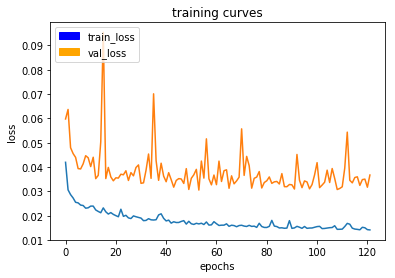

300/300 [==============================] - 149s - loss: 0.0142 - val_loss: 0.0368
Epoch 123/200
299/300 [============================>.] - ETA: 0s - loss: 0.0141

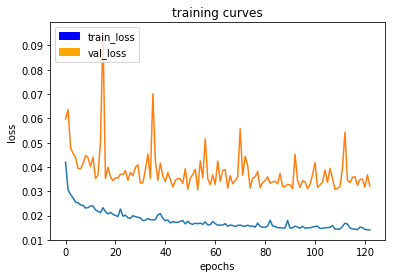

300/300 [==============================] - 149s - loss: 0.0141 - val_loss: 0.0322
Epoch 124/200
299/300 [============================>.] - ETA: 0s - loss: 0.0148

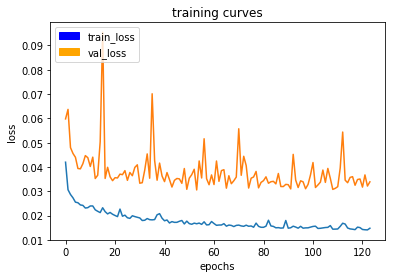

300/300 [==============================] - 150s - loss: 0.0148 - val_loss: 0.0339
Epoch 125/200
299/300 [============================>.] - ETA: 0s - loss: 0.0148

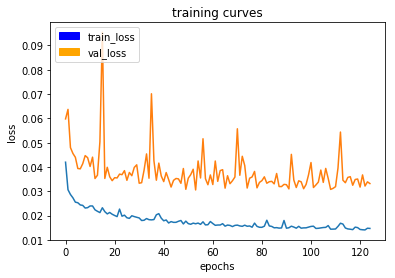

300/300 [==============================] - 150s - loss: 0.0148 - val_loss: 0.0332
Epoch 126/200
299/300 [============================>.] - ETA: 0s - loss: 0.0149

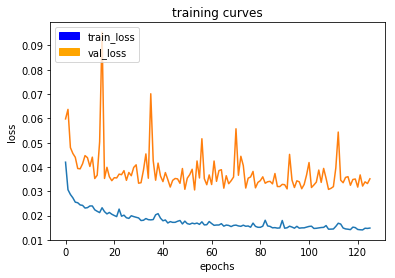

300/300 [==============================] - 151s - loss: 0.0149 - val_loss: 0.0352
Epoch 127/200
299/300 [============================>.] - ETA: 0s - loss: 0.0155

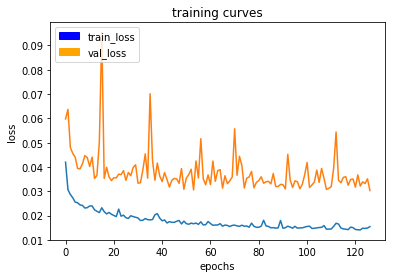

300/300 [==============================] - 151s - loss: 0.0155 - val_loss: 0.0303
Epoch 128/200
299/300 [============================>.] - ETA: 0s - loss: 0.0141

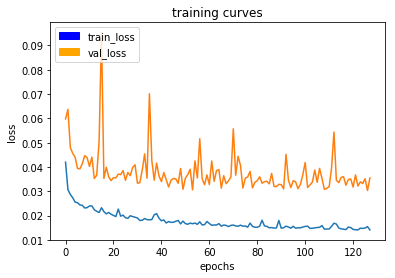

300/300 [==============================] - 150s - loss: 0.0141 - val_loss: 0.0355
Epoch 129/200
299/300 [============================>.] - ETA: 0s - loss: 0.0144

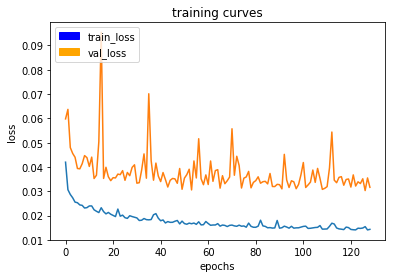

300/300 [==============================] - 150s - loss: 0.0144 - val_loss: 0.0316
Epoch 130/200
299/300 [============================>.] - ETA: 0s - loss: 0.0145

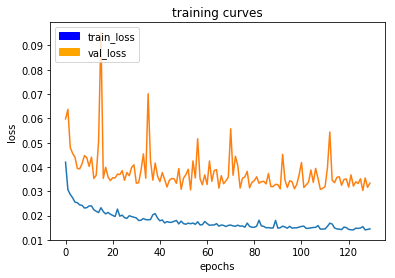

300/300 [==============================] - 150s - loss: 0.0145 - val_loss: 0.0334
Epoch 131/200
299/300 [============================>.] - ETA: 0s - loss: 0.0152

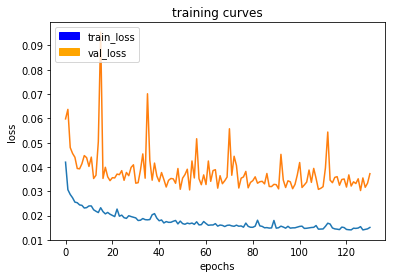

300/300 [==============================] - 151s - loss: 0.0152 - val_loss: 0.0372
Epoch 132/200
299/300 [============================>.] - ETA: 0s - loss: 0.0143

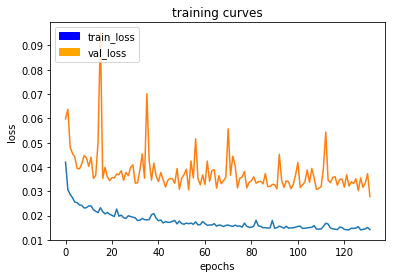

300/300 [==============================] - 151s - loss: 0.0143 - val_loss: 0.0278
Epoch 133/200
299/300 [============================>.] - ETA: 0s - loss: 0.0141

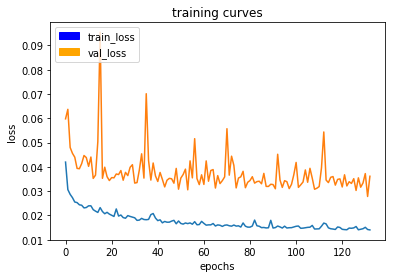

300/300 [==============================] - 151s - loss: 0.0141 - val_loss: 0.0362
Epoch 134/200
299/300 [============================>.] - ETA: 0s - loss: 0.0152

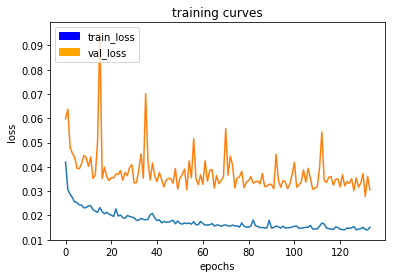

300/300 [==============================] - 151s - loss: 0.0152 - val_loss: 0.0306
Epoch 135/200
299/300 [============================>.] - ETA: 0s - loss: 0.0150

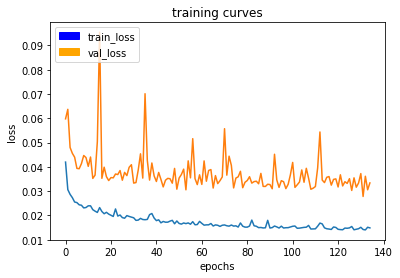

300/300 [==============================] - 151s - loss: 0.0150 - val_loss: 0.0334
Epoch 136/200
299/300 [============================>.] - ETA: 0s - loss: 0.0144

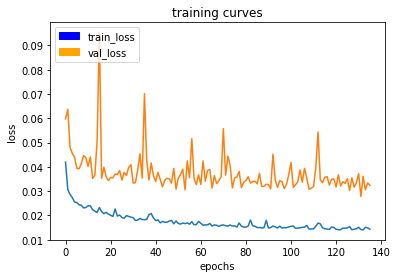

300/300 [==============================] - 150s - loss: 0.0144 - val_loss: 0.0324
Epoch 137/200
299/300 [============================>.] - ETA: 0s - loss: 0.0147

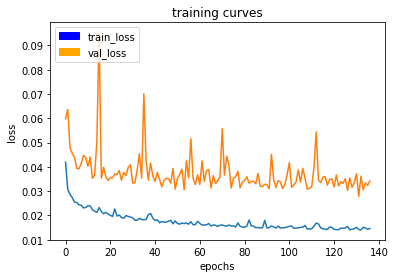

300/300 [==============================] - 151s - loss: 0.0147 - val_loss: 0.0342
Epoch 138/200
299/300 [============================>.] - ETA: 0s - loss: 0.0139

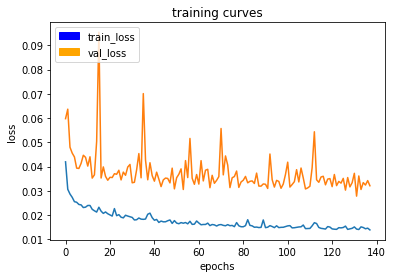

300/300 [==============================] - 151s - loss: 0.0139 - val_loss: 0.0321
Epoch 139/200
299/300 [============================>.] - ETA: 0s - loss: 0.0145

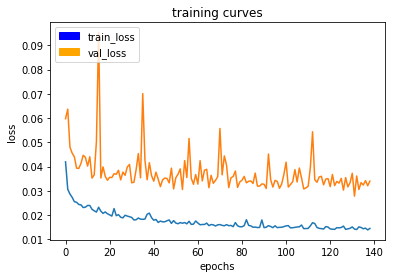

300/300 [==============================] - 151s - loss: 0.0145 - val_loss: 0.0340
Epoch 140/200
299/300 [============================>.] - ETA: 0s - loss: 0.0148

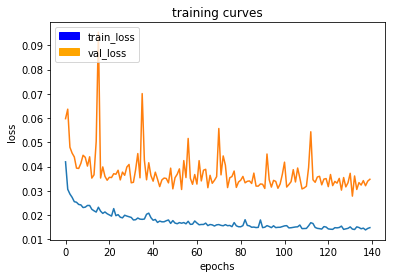

300/300 [==============================] - 151s - loss: 0.0148 - val_loss: 0.0348
Epoch 141/200
299/300 [============================>.] - ETA: 0s - loss: 0.0142

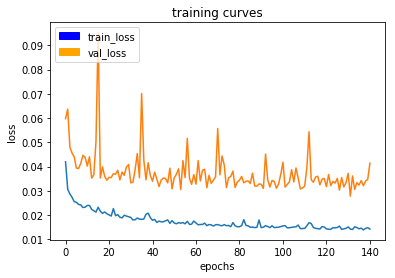

300/300 [==============================] - 151s - loss: 0.0142 - val_loss: 0.0414
Epoch 142/200
299/300 [============================>.] - ETA: 0s - loss: 0.0143

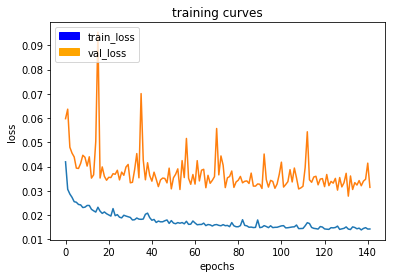

300/300 [==============================] - 150s - loss: 0.0143 - val_loss: 0.0315
Epoch 143/200
299/300 [============================>.] - ETA: 0s - loss: 0.0144

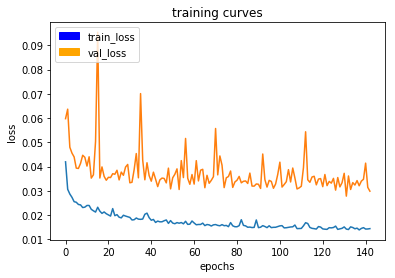

300/300 [==============================] - 150s - loss: 0.0144 - val_loss: 0.0299
Epoch 144/200
299/300 [============================>.] - ETA: 0s - loss: 0.0141

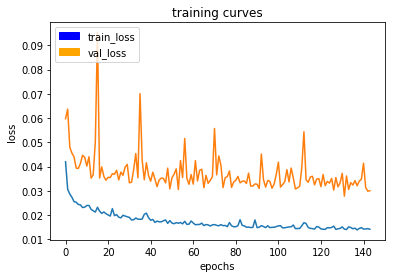

300/300 [==============================] - 151s - loss: 0.0142 - val_loss: 0.0301
Epoch 145/200
299/300 [============================>.] - ETA: 0s - loss: 0.0163

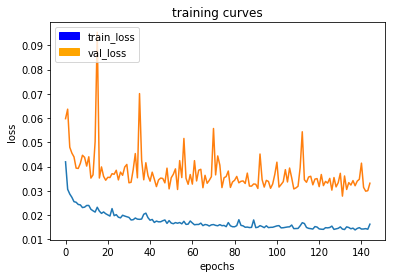

300/300 [==============================] - 151s - loss: 0.0163 - val_loss: 0.0332
Epoch 146/200
299/300 [============================>.] - ETA: 0s - loss: 0.0149

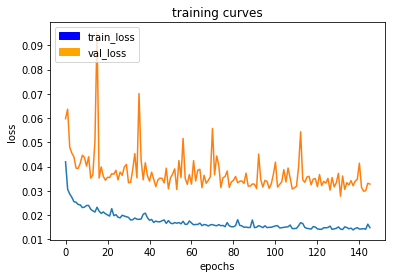

300/300 [==============================] - 151s - loss: 0.0149 - val_loss: 0.0328
Epoch 147/200
299/300 [============================>.] - ETA: 0s - loss: 0.0139

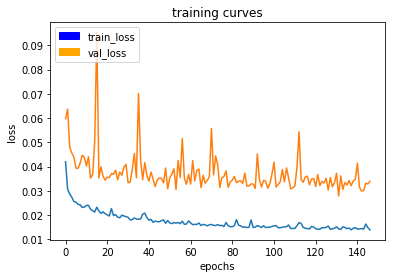

300/300 [==============================] - 151s - loss: 0.0139 - val_loss: 0.0339
Epoch 148/200
299/300 [============================>.] - ETA: 0s - loss: 0.0141

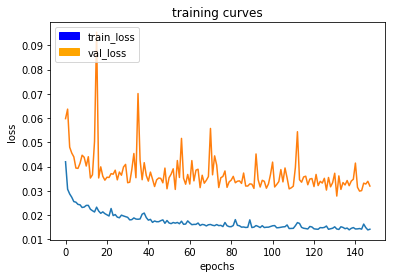

300/300 [==============================] - 151s - loss: 0.0141 - val_loss: 0.0320
Epoch 149/200
299/300 [============================>.] - ETA: 0s - loss: 0.0140

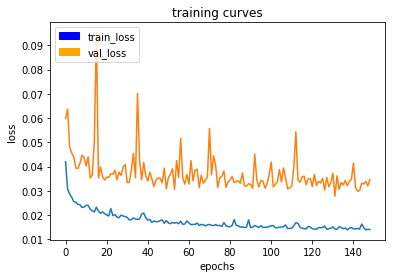

300/300 [==============================] - 151s - loss: 0.0141 - val_loss: 0.0347
Epoch 150/200
299/300 [============================>.] - ETA: 0s - loss: 0.0145

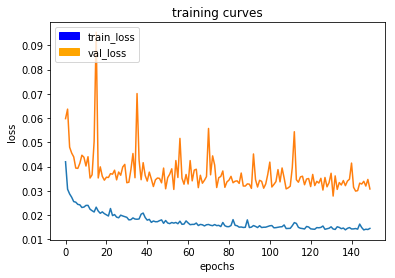

300/300 [==============================] - 151s - loss: 0.0145 - val_loss: 0.0308
Epoch 151/200
299/300 [============================>.] - ETA: 0s - loss: 0.0140

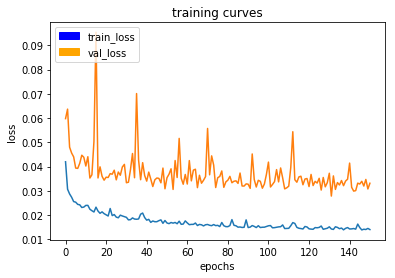

300/300 [==============================] - 152s - loss: 0.0140 - val_loss: 0.0331
Epoch 152/200
299/300 [============================>.] - ETA: 0s - loss: 0.0161

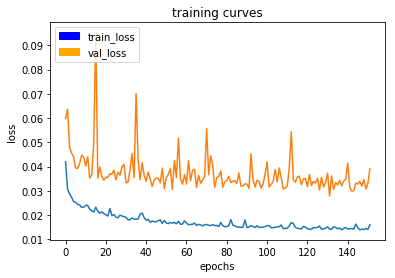

300/300 [==============================] - 152s - loss: 0.0161 - val_loss: 0.0391
Epoch 153/200
299/300 [============================>.] - ETA: 0s - loss: 0.0151

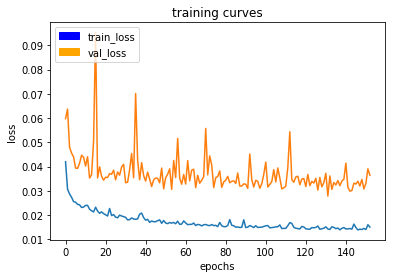

300/300 [==============================] - 151s - loss: 0.0151 - val_loss: 0.0364
Epoch 154/200
299/300 [============================>.] - ETA: 0s - loss: 0.0148

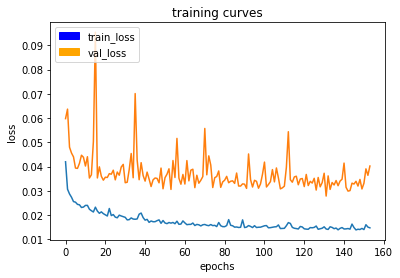

300/300 [==============================] - 150s - loss: 0.0148 - val_loss: 0.0402
Epoch 155/200
299/300 [============================>.] - ETA: 0s - loss: 0.0143

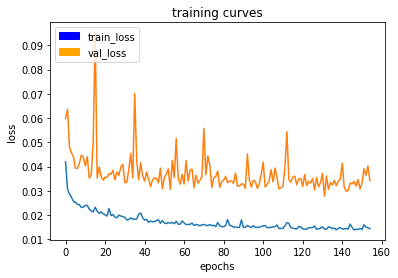

300/300 [==============================] - 150s - loss: 0.0144 - val_loss: 0.0342
Epoch 156/200
299/300 [============================>.] - ETA: 0s - loss: 0.0142

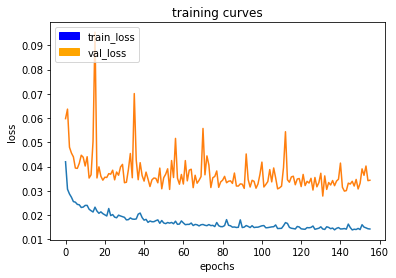

300/300 [==============================] - 151s - loss: 0.0142 - val_loss: 0.0344
Epoch 157/200
299/300 [============================>.] - ETA: 0s - loss: 0.0138

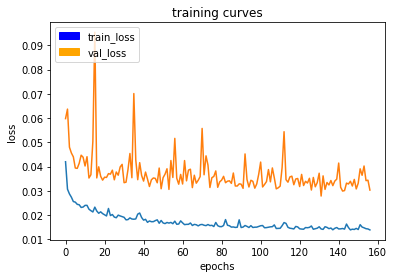

300/300 [==============================] - 151s - loss: 0.0138 - val_loss: 0.0303
Epoch 158/200
299/300 [============================>.] - ETA: 0s - loss: 0.0140

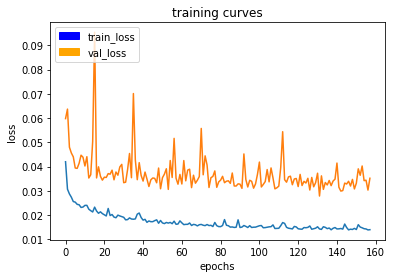

300/300 [==============================] - 150s - loss: 0.0140 - val_loss: 0.0352
Epoch 159/200
299/300 [============================>.] - ETA: 0s - loss: 0.0139

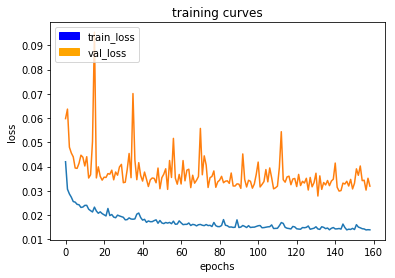

300/300 [==============================] - 150s - loss: 0.0139 - val_loss: 0.0319
Epoch 160/200
299/300 [============================>.] - ETA: 0s - loss: 0.0138

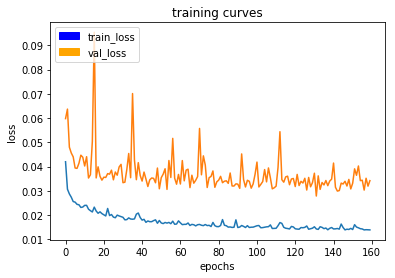

300/300 [==============================] - 150s - loss: 0.0138 - val_loss: 0.0342
Epoch 161/200
299/300 [============================>.] - ETA: 0s - loss: 0.0157

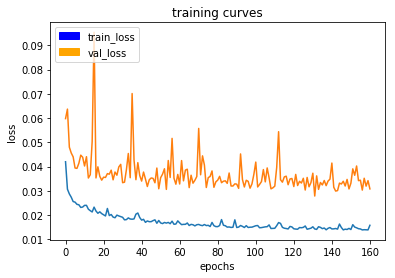

300/300 [==============================] - 150s - loss: 0.0157 - val_loss: 0.0308
Epoch 162/200
299/300 [============================>.] - ETA: 0s - loss: 0.0149

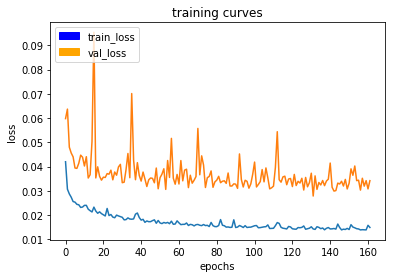

300/300 [==============================] - 150s - loss: 0.0149 - val_loss: 0.0342
Epoch 163/200
299/300 [============================>.] - ETA: 0s - loss: 0.0141

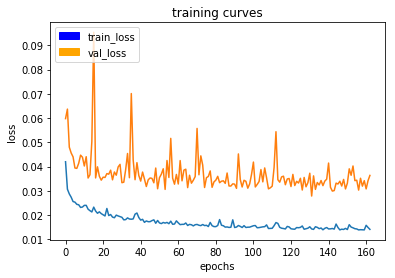

300/300 [==============================] - 151s - loss: 0.0141 - val_loss: 0.0363
Epoch 164/200
299/300 [============================>.] - ETA: 0s - loss: 0.0139

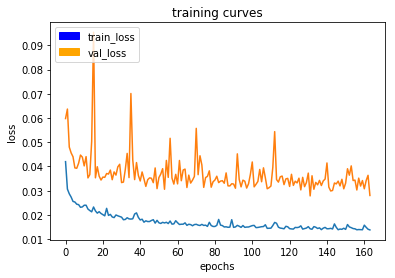

300/300 [==============================] - 151s - loss: 0.0139 - val_loss: 0.0280
Epoch 165/200
299/300 [============================>.] - ETA: 0s - loss: 0.0141

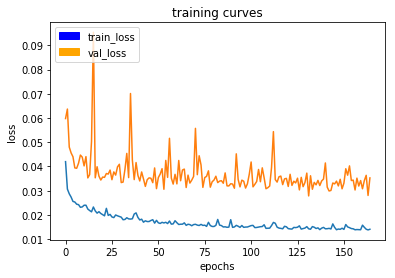

300/300 [==============================] - 151s - loss: 0.0141 - val_loss: 0.0353
Epoch 166/200
299/300 [============================>.] - ETA: 0s - loss: 0.0138

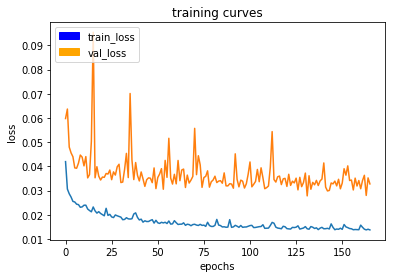

300/300 [==============================] - 151s - loss: 0.0138 - val_loss: 0.0328
Epoch 167/200
299/300 [============================>.] - ETA: 0s - loss: 0.0138

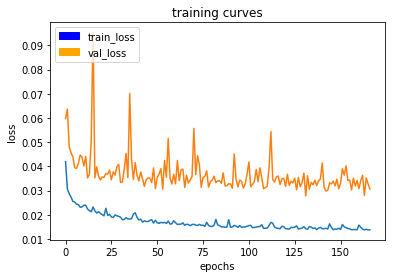

300/300 [==============================] - 151s - loss: 0.0138 - val_loss: 0.0306
Epoch 168/200
299/300 [============================>.] - ETA: 0s - loss: 0.0141

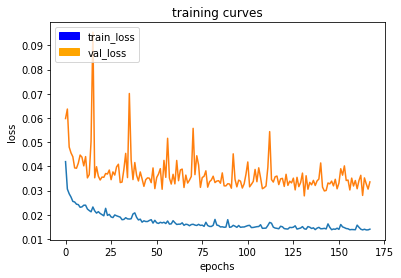

300/300 [==============================] - 151s - loss: 0.0141 - val_loss: 0.0336
Epoch 169/200
299/300 [============================>.] - ETA: 0s - loss: 0.0142

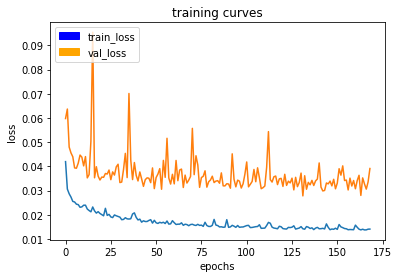

300/300 [==============================] - 151s - loss: 0.0142 - val_loss: 0.0391
Epoch 170/200
299/300 [============================>.] - ETA: 0s - loss: 0.0154

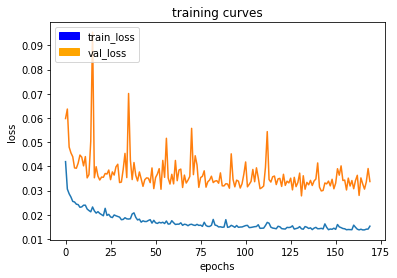

300/300 [==============================] - 150s - loss: 0.0154 - val_loss: 0.0338
Epoch 171/200
299/300 [============================>.] - ETA: 0s - loss: 0.0157

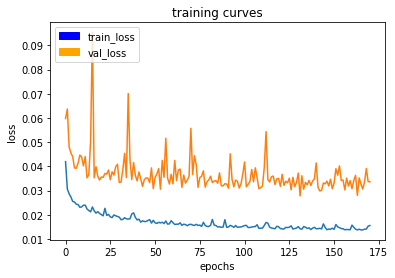

300/300 [==============================] - 150s - loss: 0.0157 - val_loss: 0.0336
Epoch 172/200
299/300 [============================>.] - ETA: 0s - loss: 0.0138

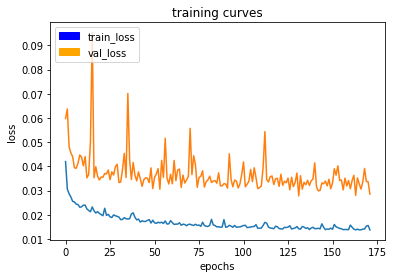

300/300 [==============================] - 150s - loss: 0.0138 - val_loss: 0.0285
Epoch 173/200
299/300 [============================>.] - ETA: 0s - loss: 0.0143

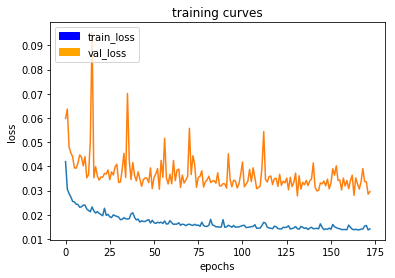

300/300 [==============================] - 151s - loss: 0.0142 - val_loss: 0.0296
Epoch 174/200
299/300 [============================>.] - ETA: 0s - loss: 0.0140

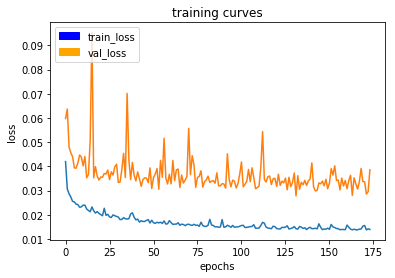

300/300 [==============================] - 151s - loss: 0.0140 - val_loss: 0.0386
Epoch 175/200
299/300 [============================>.] - ETA: 0s - loss: 0.0146

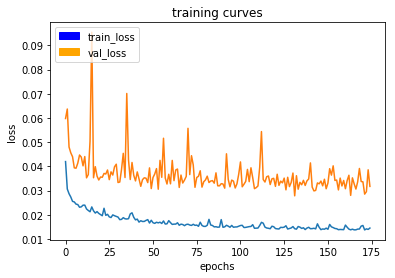

300/300 [==============================] - 150s - loss: 0.0146 - val_loss: 0.0317
Epoch 176/200
299/300 [============================>.] - ETA: 0s - loss: 0.0139

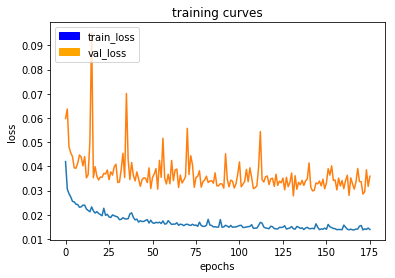

300/300 [==============================] - 151s - loss: 0.0140 - val_loss: 0.0359
Epoch 177/200
299/300 [============================>.] - ETA: 0s - loss: 0.0158

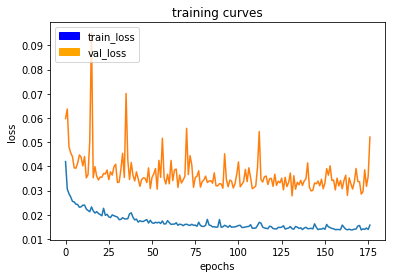

300/300 [==============================] - 151s - loss: 0.0158 - val_loss: 0.0521
Epoch 178/200
299/300 [============================>.] - ETA: 0s - loss: 0.0179

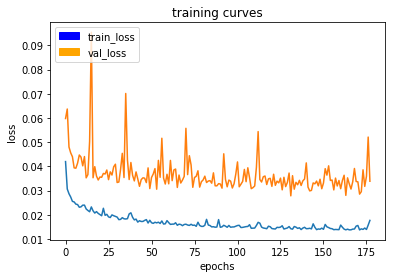

300/300 [==============================] - 151s - loss: 0.0179 - val_loss: 0.0339
Epoch 179/200
299/300 [============================>.] - ETA: 0s - loss: 0.0162

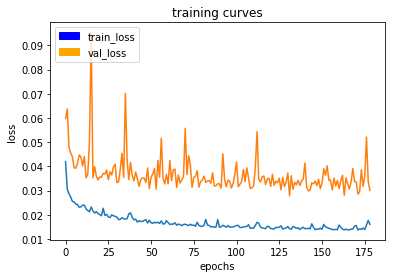

300/300 [==============================] - 151s - loss: 0.0162 - val_loss: 0.0301
Epoch 180/200
299/300 [============================>.] - ETA: 0s - loss: 0.0144

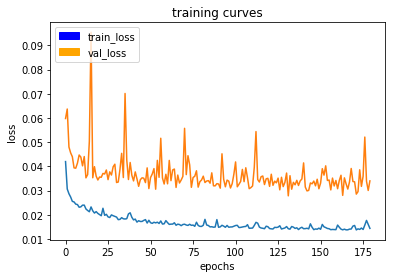

300/300 [==============================] - 150s - loss: 0.0144 - val_loss: 0.0340
Epoch 181/200
299/300 [============================>.] - ETA: 0s - loss: 0.0137

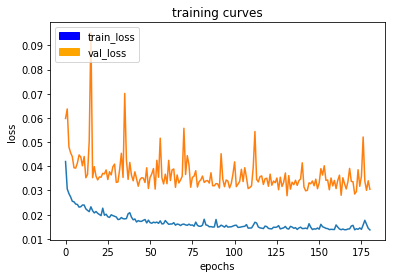

300/300 [==============================] - 151s - loss: 0.0137 - val_loss: 0.0305
Epoch 182/200
299/300 [============================>.] - ETA: 0s - loss: 0.0138

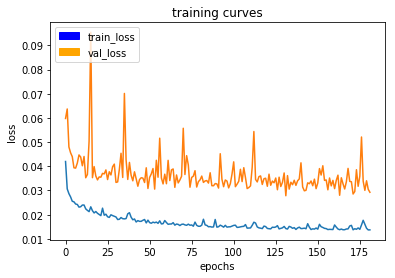

300/300 [==============================] - 150s - loss: 0.0138 - val_loss: 0.0293
Epoch 183/200
299/300 [============================>.] - ETA: 0s - loss: 0.0150

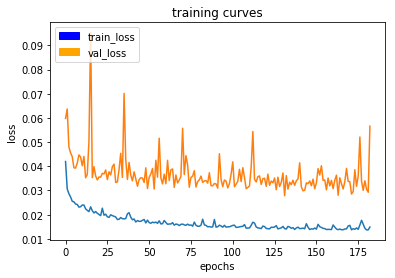

300/300 [==============================] - 150s - loss: 0.0151 - val_loss: 0.0566
Epoch 184/200
299/300 [============================>.] - ETA: 0s - loss: 0.0157

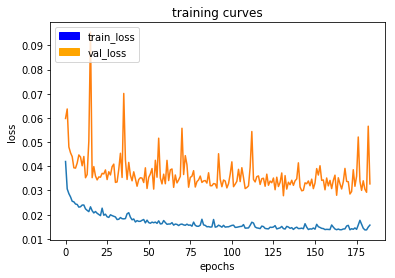

300/300 [==============================] - 150s - loss: 0.0157 - val_loss: 0.0327
Epoch 185/200
299/300 [============================>.] - ETA: 0s - loss: 0.0139

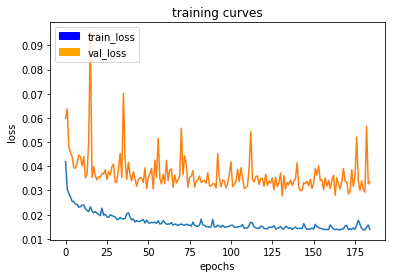

300/300 [==============================] - 150s - loss: 0.0139 - val_loss: 0.0336
Epoch 186/200
299/300 [============================>.] - ETA: 0s - loss: 0.0136

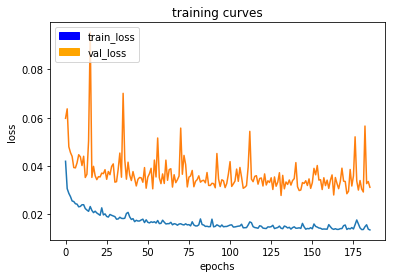

300/300 [==============================] - 150s - loss: 0.0136 - val_loss: 0.0312
Epoch 187/200
299/300 [============================>.] - ETA: 0s - loss: 0.0137

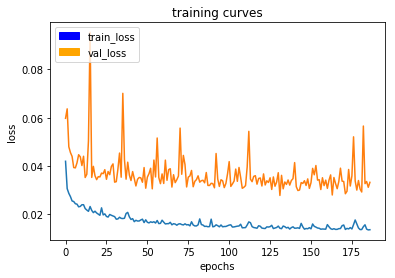

300/300 [==============================] - 150s - loss: 0.0137 - val_loss: 0.0333
Epoch 188/200
299/300 [============================>.] - ETA: 0s - loss: 0.0136

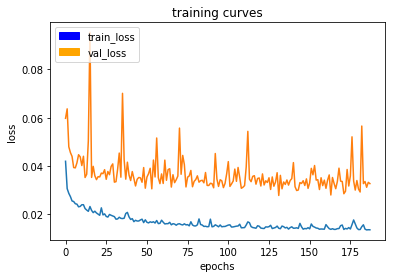

300/300 [==============================] - 149s - loss: 0.0136 - val_loss: 0.0327
Epoch 189/200
299/300 [============================>.] - ETA: 0s - loss: 0.0137

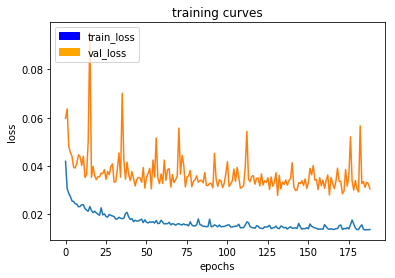

300/300 [==============================] - 150s - loss: 0.0137 - val_loss: 0.0306
Epoch 190/200
299/300 [============================>.] - ETA: 0s - loss: 0.0138

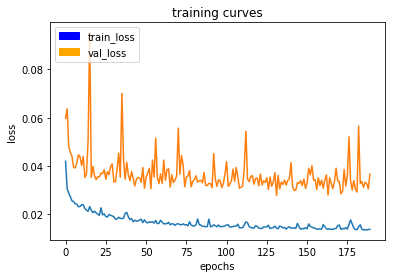

300/300 [==============================] - 150s - loss: 0.0138 - val_loss: 0.0368
Epoch 191/200
299/300 [============================>.] - ETA: 0s - loss: 0.0152

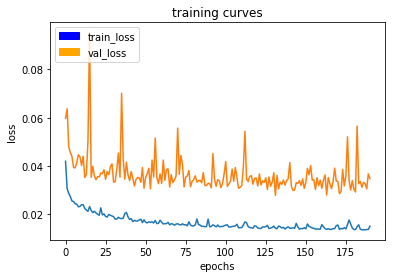

300/300 [==============================] - 150s - loss: 0.0152 - val_loss: 0.0348
Epoch 192/200
299/300 [============================>.] - ETA: 0s - loss: 0.0147

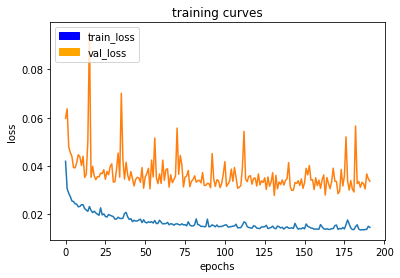

300/300 [==============================] - 150s - loss: 0.0147 - val_loss: 0.0337
Epoch 193/200
299/300 [============================>.] - ETA: 0s - loss: 0.0141

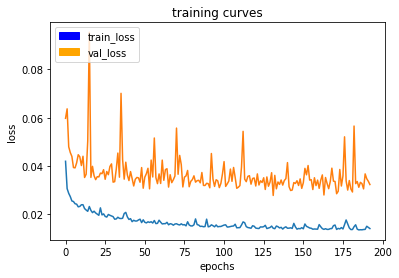

300/300 [==============================] - 150s - loss: 0.0141 - val_loss: 0.0323
Epoch 194/200
299/300 [============================>.] - ETA: 0s - loss: 0.0136

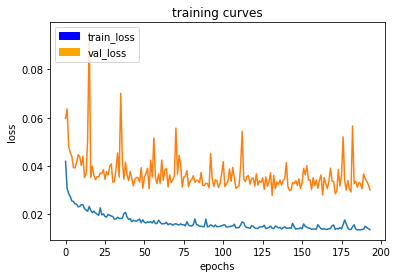

300/300 [==============================] - 150s - loss: 0.0136 - val_loss: 0.0301
Epoch 195/200
299/300 [============================>.] - ETA: 0s - loss: 0.0151

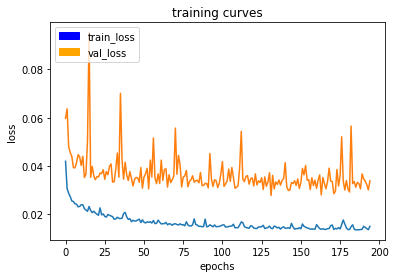

300/300 [==============================] - 151s - loss: 0.0151 - val_loss: 0.0339
Epoch 196/200
299/300 [============================>.] - ETA: 0s - loss: 0.0139

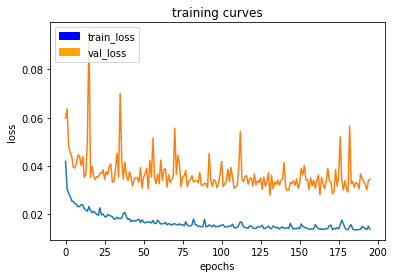

300/300 [==============================] - 151s - loss: 0.0139 - val_loss: 0.0345
Epoch 197/200
299/300 [============================>.] - ETA: 0s - loss: 0.0136

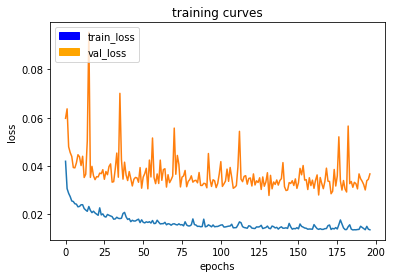

300/300 [==============================] - 150s - loss: 0.0136 - val_loss: 0.0368
Epoch 198/200
299/300 [============================>.] - ETA: 0s - loss: 0.0138

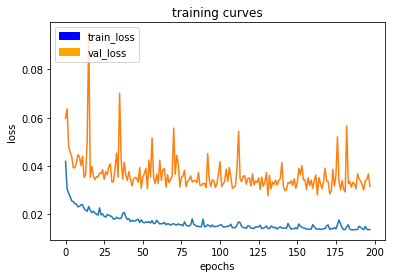

300/300 [==============================] - 150s - loss: 0.0138 - val_loss: 0.0317
Epoch 199/200
299/300 [============================>.] - ETA: 0s - loss: 0.0137

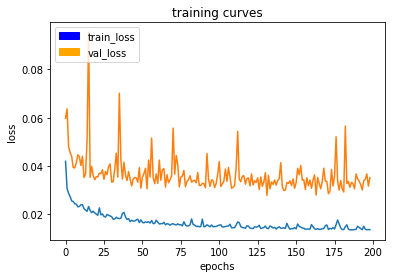

300/300 [==============================] - 150s - loss: 0.0137 - val_loss: 0.0352
Epoch 200/200
299/300 [============================>.] - ETA: 0s - loss: 0.0137

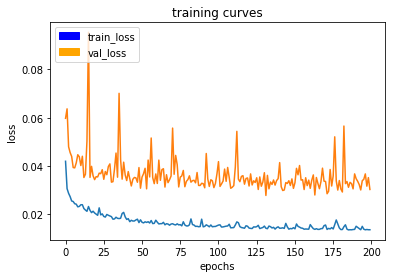

300/300 [==============================] - 150s - loss: 0.0137 - val_loss: 0.0303


In [29]:
"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
# Define the Keras model and compile it for training
model = models.Model(inputs=inputs, outputs=output_layer)

model.compile(optimizer=keras.optimizers.Adam(learning_rate), loss='categorical_crossentropy')

# Data iterators for loading the training and validation data
train_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                               data_folder=os.path.join('..', 'data', 'train'),
                                               image_shape=image_shape,
                                               shift_aug=True)

val_iter = data_iterator.BatchIteratorSimple(batch_size=batch_size,
                                             data_folder=os.path.join('..', 'data', 'validation'),
                                             image_shape=image_shape)

logger_cb = plotting_tools.LoggerPlotter()
callbacks = [logger_cb]

model.fit_generator(train_iter,
                    steps_per_epoch = steps_per_epoch, # the number of batches per epoch,
                    epochs = num_epochs, # the number of epochs to train for,
                    validation_data = val_iter, # validation iterator
                    validation_steps = validation_steps, # the number of batches to validate on
                    callbacks=callbacks,
                    workers = workers)

In [30]:
# Save your trained model weights
weight_file_name = 'model_weights'
model_tools.save_network(model,weight_file_name)

## Prediction<a id='prediction'></a>

In [12]:
# If you need to load a model which you previously trained you can uncomment the codeline that calls the function below.

# weight_file_name = 'model_weights'
# restored_model = model_tools.load_network(weight_file_name)

In [11]:
# generate predictions, save in the runs, directory.
run_number = 'run1'
validation_path, output_path = model_tools.write_predictions_grade_set(model,run_number,'validation')

In [12]:
# take a look at predictions
# validation_path = 'validation'
im_files = plotting_tools.get_im_file_sample(run_number,validation_path) 
for i in range(3):
    im_tuple = plotting_tools.load_images(im_files[i])
    plotting_tools.show_images(im_tuple)

IndexError: index 631 is out of bounds for axis 0 with size 0

## Evaluation<a id='evaluation'></a>
Let's evaluate your model!

In [13]:
scoring_utils.score_run(validation_path, output_path)

number of validation samples intersection over the union evaulated on 1184
average intersection over union for background is 0.9918344718538995
average intersection over union for other people is 0.29348541366836456
average intersection over union for hero is 0.13460262142911952
global average intersection over union is 0.47330750231712787
